In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
import pickle
from matplotlib.ticker import PercentFormatter

In [2]:
def logistic_regression(x, y):
    try:
        X = np.transpose([np.ones(len(x)), x])
        model_fit = sm.Logit(y,X).fit(maxiter=50)
        coeff = 1 if model_fit.params[1] > 0 else -1
        return (model_fit.prsquared, coeff, model_fit)
    except np.linalg.LinAlgError:
        return (0, 0, None)
    except sm.tools.sm_exceptions.PerfectSeparationError:
        coeff = 1 if max(x[np.array(y, dtype=bool)]) == max(x) else -1 
        return (1, coeff, None) # Data is linearly separable

def sample_trials(alevel_idxs, n_samples):
    trial_per_alevel = 500
    trials_offset = 200 # Only consider the second half of the alevel
    
    trials_to_sample = []
    for n_bin in alevel_idxs:
        trial_s = n_bin * trial_per_alevel + trials_offset
        trial_t = (n_bin + 1) * trial_per_alevel
        trials_to_sample = trials_to_sample + list(range(trial_s, trial_t))
    return np.array(random.sample(trials_to_sample, n_samples))

In [41]:
def get_data(data_dir):
    N_PFC_NEURONS = 500
    N_MD_NEURONS = 2
    N_OUTPUT_NEURONS = 2
    TRIAL_TIME = 200

    s_trial = 0
    t_trial = 4000
    n_trials = t_trial - s_trial

    rPFC_trials = np.zeros((n_trials, TRIAL_TIME, N_PFC_NEURONS))
    task_input = np.zeros((2, n_trials))
    v1v2_values = np.zeros((2, n_trials))
    wPFC_output = np.zeros((n_trials, N_OUTPUT_NEURONS, N_PFC_NEURONS))

    for i in range(s_trial, t_trial):
        with open(data_dir + "/" + str(i) + ".json") as json_file:
            data = json.load(json_file)
            idx = i - s_trial

            rPFC = np.array(data["network_rates"]["r_PFC"])
            rPFC_trials[idx,:,:] = rPFC

            trial_task_input = np.array(data["trial_data"]["input"])
            task_input[:,idx] = trial_task_input[:2]
            v1v2_values[:,idx] = trial_task_input[2:4]
            
            wPFC_output[idx,:,:] = np.array(data["network_weights"]["w_outputs"])

    return (rPFC_trials, task_input, v1v2_values, wPFC_output)

def get_trials(v1v2_values, starts_with_90):
    TRIAL_SAMPLE_SIZE = 300
    N_PFC_NEURONS = 500

    # OLD! Block schedule ['30', '90', '10', '90', '70', '30', '10', '70']
    
    if starts_with_90:
        alevel_90_idxs = [0,2,4,6]
        alevel_10_idxs = [1,3,5,7]
    else:
        alevel_10_idxs = [0,2,4,6]
        alevel_90_idxs = [1,3,5,7]

    # Randomly sample trials for analysis from the second half of each alevel
    # We ensure all alevels are equally represented

    alevel_90_trials = sample_trials(alevel_90_idxs, TRIAL_SAMPLE_SIZE)
    alevel_10_trials = sample_trials(alevel_10_idxs, TRIAL_SAMPLE_SIZE)
    match_trials = alevel_90_trials
    nonmatch_trials = alevel_10_trials
    trials = np.concatenate((match_trials, nonmatch_trials))
    
    match_trials = match_trials[v1v2_values[0,match_trials] >= 0.6]
    nonmatch_trials = nonmatch_trials[v1v2_values[0,nonmatch_trials] <= 0.4]
    trials = np.concatenate((match_trials, nonmatch_trials))
    
    return (match_trials, nonmatch_trials, trials)

def score_cue_like(rPFC_trials, task_input, match_trials, nonmatch_trials):
    N_PFC_NEURONS = 500
    N_MD_NEURONS = 2
    N_OUTPUT_NEURONS = 2
    TRIAL_TIME = 250
    
    CUE_TIME = 100
    
    cuetime_s = math.floor(CUE_TIME - (CUE_TIME / 2))
    cuetime_t = CUE_TIME

    # NOTE: Testing outcome period, not cue
#     cuetime_s = 150
#     cuetime_t = 200
    
    cue_match = task_input[0, match_trials]
    cue_nonmatch = task_input[0, nonmatch_trials]
    
    rsquareds = np.empty((N_PFC_NEURONS, 2))
    rsquareds[:] = np.nan
    betas = np.empty((N_PFC_NEURONS, 2))
    rsquareds[:] = np.nan
    
    for neuron_idx in range(0,N_PFC_NEURONS): 
        fr_match = np.mean(rPFC_trials[match_trials, cuetime_s:cuetime_t, neuron_idx],1)
        fr_nonmatch = np.mean(rPFC_trials[nonmatch_trials, cuetime_s:cuetime_t, neuron_idx],1)
        
        (r2_match, b_match, model_fit_match) = logistic_regression(fr_match, cue_match)
        (r2_nonmatch, b_nonmatch, model_fit_nonmatch) = logistic_regression(fr_nonmatch, cue_nonmatch)
    
        r2_match = 0 if r2_match < 0 else r2_match
        r2_nonmatch = 0 if r2_nonmatch < 0 else r2_nonmatch
            
        rsquareds[neuron_idx,:] = [r2_match, r2_nonmatch]
        betas[neuron_idx,:] = [b_match, b_nonmatch]
        
    return (rsquareds, betas)

In [5]:
def save_obj(name, obj):
    with open('/om2/group/halassa/PFCMD-ali-sabrina/many_seeds/'+ name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('/om2/group/halassa/PFCMD-ali-sabrina/many_seeds/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    

In [6]:
# RUNS_MD = ["seed0_MDon", "seed42_MDon", "seed778_MDon"]
# RUNS_MD_NO = ["seed0_MDoff", "seed42_MDoff", "seed778_MDoff"]

# RUNS_MD = ["seed12_MDon_10", "seed312_MDon_10", "seed400_MDon_10"]
# RUNS_MD_NO = ["seed12_MDoff_10", "seed312_MDoff_10", "seed400_MDoff_10"]

# for i in range(len(RUNS_MD)):
#     data_MDon = get_data("/om2/group/halassa/PFCMD-ali-sabrina/" + RUNS_MD[i] + "/by_trial")
#     data_MDoff = get_data("/om2/group/halassa/PFCMD-ali-sabrina/" + RUNS_MD_NO[i] + "/by_trial")
#     save_obj(RUNS_MD[i], data_MDon)
#     save_obj(RUNS_MD_NO[i], data_MDoff)

JSONDecodeError: Expecting ',' delimiter: line 1 column 1041683 (char 1041682)

In [34]:
data_MDoff = get_data("/om2/group/halassa/PFCMD-ali-sabrina/" + "seed400_MDon_10" + "/by_trial")
save_obj("seed400_MDon_10", data_MDoff)

0
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/0.json
1
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1.json
2
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2.json
3
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3.json
4
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/4.json
5
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/5.json
6
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/6.json
7
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/7.json
8
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/8.json
9
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/9.json
10
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/10.json
11
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/11.json
12
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/12.json
13
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/13.jso

116
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/116.json
117
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/117.json
118
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/118.json
119
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/119.json
120
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/120.json
121
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/121.json
122
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/122.json
123
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/123.json
124
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/124.json
125
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/125.json
126
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/126.json
127
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/127.json
128
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/128.json
129
/om2/group/halassa/PF

228
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/228.json
229
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/229.json
230
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/230.json
231
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/231.json
232
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/232.json
233
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/233.json
234
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/234.json
235
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/235.json
236
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/236.json
237
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/237.json
238
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/238.json
239
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/239.json
240
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/240.json
241
/om2/group/halassa/PF

341
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/341.json
342
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/342.json
343
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/343.json
344
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/344.json
345
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/345.json
346
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/346.json
347
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/347.json
348
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/348.json
349
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/349.json
350
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/350.json
351
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/351.json
352
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/352.json
353
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/353.json
354
/om2/group/halassa/PF

453
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/453.json
454
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/454.json
455
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/455.json
456
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/456.json
457
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/457.json
458
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/458.json
459
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/459.json
460
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/460.json
461
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/461.json
462
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/462.json
463
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/463.json
464
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/464.json
465
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/465.json
466
/om2/group/halassa/PF

566
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/566.json
567
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/567.json
568
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/568.json
569
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/569.json
570
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/570.json
571
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/571.json
572
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/572.json
573
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/573.json
574
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/574.json
575
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/575.json
576
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/576.json
577
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/577.json
578
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/578.json
579
/om2/group/halassa/PF

677
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/677.json
678
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/678.json
679
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/679.json
680
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/680.json
681
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/681.json
682
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/682.json
683
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/683.json
684
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/684.json
685
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/685.json
686
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/686.json
687
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/687.json
688
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/688.json
689
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/689.json
690
/om2/group/halassa/PF

789
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/789.json
790
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/790.json
791
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/791.json
792
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/792.json
793
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/793.json
794
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/794.json
795
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/795.json
796
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/796.json
797
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/797.json
798
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/798.json
799
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/799.json
800
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/800.json
801
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/801.json
802
/om2/group/halassa/PF

899
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/899.json
900
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/900.json
901
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/901.json
902
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/902.json
903
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/903.json
904
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/904.json
905
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/905.json
906
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/906.json
907
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/907.json
908
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/908.json
909
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/909.json
910
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/910.json
911
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/911.json
912
/om2/group/halassa/PF

1009
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1009.json
1010
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1010.json
1011
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1011.json
1012
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1012.json
1013
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1013.json
1014
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1014.json
1015
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1015.json
1016
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1016.json
1017
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1017.json
1018
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1018.json
1019
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1019.json
1020
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1020.json
1021
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1021.json

1116
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1116.json
1117
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1117.json
1118
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1118.json
1119
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1119.json
1120
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1120.json
1121
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1121.json
1122
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1122.json
1123
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1123.json
1124
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1124.json
1125
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1125.json
1126
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1126.json
1127
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1127.json
1128
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1128.json

1223
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1223.json
1224
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1224.json
1225
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1225.json
1226
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1226.json
1227
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1227.json
1228
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1228.json
1229
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1229.json
1230
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1230.json
1231
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1231.json
1232
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1232.json
1233
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1233.json
1234
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1234.json
1235
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1235.json

1333
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1333.json
1334
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1334.json
1335
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1335.json
1336
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1336.json
1337
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1337.json
1338
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1338.json
1339
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1339.json
1340
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1340.json
1341
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1341.json
1342
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1342.json
1343
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1343.json
1344
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1344.json
1345
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1345.json

1443
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1443.json
1444
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1444.json
1445
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1445.json
1446
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1446.json
1447
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1447.json
1448
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1448.json
1449
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1449.json
1450
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1450.json
1451
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1451.json
1452
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1452.json
1453
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1453.json
1454
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1454.json
1455
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1455.json

1550
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1550.json
1551
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1551.json
1552
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1552.json
1553
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1553.json
1554
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1554.json
1555
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1555.json
1556
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1556.json
1557
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1557.json
1558
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1558.json
1559
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1559.json
1560
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1560.json
1561
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1561.json
1562
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1562.json

1660
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1660.json
1661
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1661.json
1662
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1662.json
1663
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1663.json
1664
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1664.json
1665
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1665.json
1666
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1666.json
1667
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1667.json
1668
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1668.json
1669
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1669.json
1670
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1670.json
1671
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1671.json
1672
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1672.json

1768
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1768.json
1769
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1769.json
1770
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1770.json
1771
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1771.json
1772
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1772.json
1773
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1773.json
1774
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1774.json
1775
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1775.json
1776
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1776.json
1777
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1777.json
1778
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1778.json
1779
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1779.json
1780
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1780.json

1876
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1876.json
1877
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1877.json
1878
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1878.json
1879
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1879.json
1880
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1880.json
1881
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1881.json
1882
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1882.json
1883
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1883.json
1884
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1884.json
1885
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1885.json
1886
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1886.json
1887
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1887.json
1888
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1888.json

1985
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1985.json
1986
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1986.json
1987
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1987.json
1988
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1988.json
1989
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1989.json
1990
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1990.json
1991
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1991.json
1992
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1992.json
1993
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1993.json
1994
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1994.json
1995
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1995.json
1996
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1996.json
1997
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1997.json

2092
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2092.json
2093
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2093.json
2094
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2094.json
2095
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2095.json
2096
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2096.json
2097
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2097.json
2098
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2098.json
2099
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2099.json
2100
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2100.json
2101
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2101.json
2102
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2102.json
2103
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2103.json
2104
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2104.json

2201
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2201.json
2202
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2202.json
2203
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2203.json
2204
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2204.json
2205
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2205.json
2206
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2206.json
2207
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2207.json
2208
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2208.json
2209
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2209.json
2210
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2210.json
2211
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2211.json
2212
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2212.json
2213
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2213.json

2309
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2309.json
2310
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2310.json
2311
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2311.json
2312
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2312.json
2313
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2313.json
2314
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2314.json
2315
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2315.json
2316
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2316.json
2317
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2317.json
2318
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2318.json
2319
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2319.json
2320
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2320.json
2321
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2321.json

2416
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2416.json
2417
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2417.json
2418
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2418.json
2419
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2419.json
2420
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2420.json
2421
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2421.json
2422
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2422.json
2423
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2423.json
2424
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2424.json
2425
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2425.json
2426
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2426.json
2427
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2427.json
2428
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2428.json

2526
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2526.json
2527
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2527.json
2528
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2528.json
2529
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2529.json
2530
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2530.json
2531
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2531.json
2532
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2532.json
2533
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2533.json
2534
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2534.json
2535
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2535.json
2536
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2536.json
2537
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2537.json
2538
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2538.json

2636
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2636.json
2637
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2637.json
2638
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2638.json
2639
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2639.json
2640
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2640.json
2641
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2641.json
2642
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2642.json
2643
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2643.json
2644
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2644.json
2645
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2645.json
2646
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2646.json
2647
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2647.json
2648
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2648.json

2743
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2743.json
2744
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2744.json
2745
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2745.json
2746
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2746.json
2747
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2747.json
2748
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2748.json
2749
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2749.json
2750
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2750.json
2751
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2751.json
2752
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2752.json
2753
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2753.json
2754
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2754.json
2755
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2755.json

2850
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2850.json
2851
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2851.json
2852
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2852.json
2853
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2853.json
2854
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2854.json
2855
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2855.json
2856
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2856.json
2857
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2857.json
2858
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2858.json
2859
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2859.json
2860
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2860.json
2861
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2861.json
2862
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2862.json

2958
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2958.json
2959
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2959.json
2960
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2960.json
2961
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2961.json
2962
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2962.json
2963
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2963.json
2964
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2964.json
2965
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2965.json
2966
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2966.json
2967
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2967.json
2968
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2968.json
2969
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2969.json
2970
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2970.json

3068
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3068.json
3069
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3069.json
3070
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3070.json
3071
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3071.json
3072
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3072.json
3073
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3073.json
3074
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3074.json
3075
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3075.json
3076
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3076.json
3077
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3077.json
3078
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3078.json
3079
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3079.json
3080
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3080.json

3175
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3175.json
3176
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3176.json
3177
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3177.json
3178
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3178.json
3179
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3179.json
3180
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3180.json
3181
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3181.json
3182
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3182.json
3183
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3183.json
3184
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3184.json
3185
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3185.json
3186
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3186.json
3187
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3187.json

3282
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3282.json
3283
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3283.json
3284
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3284.json
3285
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3285.json
3286
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3286.json
3287
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3287.json
3288
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3288.json
3289
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3289.json
3290
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3290.json
3291
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3291.json
3292
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3292.json
3293
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3293.json
3294
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3294.json

3391
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3391.json
3392
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3392.json
3393
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3393.json
3394
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3394.json
3395
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3395.json
3396
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3396.json
3397
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3397.json
3398
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3398.json
3399
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3399.json
3400
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3400.json
3401
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3401.json
3402
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3402.json
3403
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3403.json

3498
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3498.json
3499
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3499.json
3500
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3500.json
3501
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3501.json
3502
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3502.json
3503
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3503.json
3504
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3504.json
3505
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3505.json
3506
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3506.json
3507
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3507.json
3508
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3508.json
3509
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3509.json
3510
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3510.json

3605
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3605.json
3606
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3606.json
3607
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3607.json
3608
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3608.json
3609
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3609.json
3610
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3610.json
3611
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3611.json
3612
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3612.json
3613
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3613.json
3614
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3614.json
3615
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3615.json
3616
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3616.json
3617
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3617.json

3715
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3715.json
3716
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3716.json
3717
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3717.json
3718
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3718.json
3719
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3719.json
3720
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3720.json
3721
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3721.json
3722
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3722.json
3723
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3723.json
3724
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3724.json
3725
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3725.json
3726
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3726.json
3727
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3727.json

3825
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3825.json
3826
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3826.json
3827
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3827.json
3828
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3828.json
3829
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3829.json
3830
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3830.json
3831
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3831.json
3832
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3832.json
3833
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3833.json
3834
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3834.json
3835
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3835.json
3836
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3836.json
3837
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3837.json

3932
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3932.json
3933
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3933.json
3934
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3934.json
3935
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3935.json
3936
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3936.json
3937
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3937.json
3938
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3938.json
3939
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3939.json
3940
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3940.json
3941
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3941.json
3942
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3942.json
3943
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3943.json
3944
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3944.json

In [40]:
RUNS_MD = ["seed0_MDon", "seed42_MDon", "seed778_MDon", "seed12_MDon_10", "seed312_MDon_10", "seed400_MDon_10"]
RUNS_MD_NO = ["seed0_MDoff", "seed42_MDoff", "seed778_MDoff", "seed12_MDoff_10", "seed312_MDoff_10", "seed400_MDoff_10"]

# RUNS_MD = ["seed400_MDon_10"]

scores = []
scores_noMD = []
b = []
b_noMD = []

for i in range(len(RUNS_MD)):
    starts_with_90 = i < 3
        
    (rPFC_trials, task_input, v1v2_values, wPFC_output) = load_obj(RUNS_MD[i])
    (match_trials, nonmatch_trials, trials) = get_trials(v1v2_values, starts_with_90)    
    (scores_, b_) = score_cue_like(rPFC_trials, task_input, match_trials, nonmatch_trials)

    
    (rPFC_trials_noMD, task_input_noMD, v1v2_values_noMD, wPFC_output_noMD) = load_obj(RUNS_MD_NO[i])
    (match_trials_noMD, nonmatch_trials_noMD, trials_noMD) = get_trials(v1v2_values_noMD, starts_with_90)
    (scores_noMD_, b_noMD_) = score_cue_like(rPFC_trials_noMD, task_input_noMD, match_trials_noMD, nonmatch_trials_noMD)
    
    if i == 0:
        scores = scores_
        scores_noMD = scores_noMD_
        b = b_
        b_noMD = b_noMD_
    else:
        scores = np.concatenate((scores, scores_), axis=0)
        b = np.concatenate((b, b_), axis=0)
        scores_noMD = np.concatenate((scores_noMD, scores_noMD_), axis=0)
        b_noMD = np.concatenate((b_noMD, b_noMD_), axis=0)
    

Optimization terminated successfully.
         Current function value: 0.054555
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.214599
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.112782
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.377783
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.134831
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692612
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.554293
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692514
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.248513
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.357565
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.099122
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.011613
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.052767
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.061369
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.058879
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.117418
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.008829
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.173610
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.022612
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.505

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.652120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.056758
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.662197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541310
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.061413
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.687405
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030060
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.073317
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007105
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.014058
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.691753
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.249756
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.681826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.006875
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.071525
         Iterations 9
Optimization terminated successful

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.097285
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.132476
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.444764
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.082832
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.193056
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.343028
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.209738
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.064616
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.074008
         Iterations 9
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.635524
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.074825
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.348620
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.605113
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.103331
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.679714
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.022115
         Iterations 12
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.663644
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.090387
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.434766
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.063494
         Iterations 9
         Current function value: 0.674596
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.553664
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.213243
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.064180
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.017884
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.148355
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004685
         Iterations 23
Optimization terminated successfully.
         Current function value: 0.688376
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.499588
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.671825
         Iterations 5
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692495
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.053049
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.305523
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417075
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.023269
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.580262
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.643929
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.028046
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.033366
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.076434
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690110
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.148678
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.123336
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095761
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.150904
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024003
         Iterations 10
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.095800
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.378087
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.060452
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.141969
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692174
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682591
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.665895
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.032685
         Iterations 10
         Current function value: 0.000022
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.025764
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047443
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.291991
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.042352
         Iterations 9
         Current function value: 0.196681
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.182099
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.081260
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.122445
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.039241
         Iterations 11
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.023408
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.024168
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.180045
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.077887
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.622576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.074302
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.023799
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.070730
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.071136
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.14989

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.029766
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.091114
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.045019
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.685067
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.095561
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.337897
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.169322
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.058945
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.136123
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.438567
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.268445
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.341348
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.028958
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.109947
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.092083
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.213447
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.043986
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.46165

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.078574
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.410097
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.381386
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600123
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.023829
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.057811
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.129802
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.034700
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.677828
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598458

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.387099
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.090749
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.058905
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.120147
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.678944
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.101877
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.498399
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687195
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.226070
         Iterations 8
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.025715
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.296138
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.006747
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.432389
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.062236
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.233040
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.165898
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.117627
         Iterations 8
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.033519
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.674584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.052153
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.607239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.033384
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.421510
         Iterations 7
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.324615
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.489131
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.076514
         Iterations 9
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.565478
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.588165
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445168
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.053186
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.646804
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.110666
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.120285
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.440013
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690312
         Iterations 5
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.029766
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.440745
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.071908
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690506
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.262392
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.591217
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.044115
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.337227
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.016670
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.323041
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436332
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.027886
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.081450
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.120106
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.027918
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.052407
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.042944
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.174278
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.34899

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.108040
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.228782
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.012942
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.683631
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.692313
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673468
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691816
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.514852
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687864
         Iterations 7
         Current function value: 0.680441
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.123444
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.155340
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.093703
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.477243
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.046790
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.169665
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.014230
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.692692
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.158738
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.680773
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.076227
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.399637
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.037483
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088868
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.090384
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.214854
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.088138
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.085401
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.643050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.138960
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.013097
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.673720
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411143
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.295234
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.677668
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.043569
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.688900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.445547
         Iterations 9
         Current function value: 0.461676
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035954
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.022645
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.167974
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.111340
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.046352
         Iterations 10
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.687789
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115789
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.057205
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.660592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.038971
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.460512
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.039873
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.176815
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.568199
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.188327
         Iterations 8
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.308825
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.086267
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.007368
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.295974
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.501412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.073534
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.056780
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.034386
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.044440
         Iterations 9
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.129975
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.049593
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.051009
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.284385
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691822
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.573970
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690798
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.117083
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.205824
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.682311
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.692355
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.072540
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.158829
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683412
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.017143
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.626126
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046320
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.528266
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.066085
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.281699
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.090054
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.471206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.059603
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.218383
         Iterations 7
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010547
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.264372
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.304908
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.092066
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.515193
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.126276
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.339271
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008244
         Iterations 13
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.076296
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.057085
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.277049
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.102142
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.656188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.136642
         Iterations 8
         Current function value: 0.625835
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074318
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.689699
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677980
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.576740
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.680180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691711
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.095480
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081751
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090533
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692160
         Iterations 4
         Current function value: 0.124009
         Iterations: 50
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.073696
         Iterations 12
         Current function value: 0.035486
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687330
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691577
         Iterations 5
         Current function value: 0.124009
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692147
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.660064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.101916
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.588159
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.052853
         Iterations 10
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684476
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689214
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.147854
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.681002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.177020
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.686648
         Iterations 4
         Current function value: 0.687789
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020320
         Iterations 18
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.568199
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.681790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.229695
         Iterations 8
         Current function value: 0.133024
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130341
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.686215
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.035493
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.690219
         Iterations 16
         Current function value: 0.035486
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690275
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.035486
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.188156
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.428027
         Iterations 9
         Current function value: 0.105000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.162647
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.446080
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.339807
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.666498
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692189
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.679986
         Iterations 6
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690077
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.685298
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.831582
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.452698
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690301
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678827
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.064969
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.023044
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.687789
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020510
         Iterations 45
         Current function value: 0.689698
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.292963
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.023669
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.691422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686799
         Iterations 5
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039849
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.529963
         Iterations 7
         Current function value: 0.689698
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660699
         Iterations 8
         Current function value: 0.689698
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687056
         Iterations 5
         Current function value: inf
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.468494
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689119
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689157
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.076328
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.692288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689741
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.620269
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684219
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.608629
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.013158
         Iterations 12
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.204766
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692694
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692189
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692694
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.044585
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.685974
         Iterations 6
         Current function value: 0.689994
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667543
         Iterations 5
         Current function value: 0.689698
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.405997
         Iterations 7
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.020298
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038099
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084126
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.689787
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.155050
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.090436
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.039510
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.024705
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.632926
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.035716
         Iterations 18
         Current function value: 0.690268
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687789
         Iterations 24
Optimization terminated successfully.
         Current function value: 0.048650
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.648787
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.569807
         Iterations 7
Optimizatio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.689698
         Iterations 42
Optimization terminated successfully.
         Current function value: 0.115490
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.253207
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.138393
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.255669
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.013052
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.020470
         Iterations 18
         Current function value: 0.688235
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.124234
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.590100
         Iterations 8
Optimizatio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.035491
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.684248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.190112
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.106791
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.689870
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.144124
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.297792
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.093600
         Iterations 19
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.035380
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.691249
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.152493
         Iterations 9
         Current function value: 0.020269
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.253449
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691743
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.251966

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations 8
Optimization terminated successfully.
         Current function value: 0.180371
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.506385
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692801
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.037188
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.031728
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.044895
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.058098
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098622
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.309621
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.258199
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.331474
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.690137
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.462365
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.099207
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692584
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.677145
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691709
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.317017
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041322
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.176834
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.177322
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.193387
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.537776
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648264
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.296386
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.174508
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.531523
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.178130
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.561719
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.160137
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.487449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.140865
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692704
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.020968
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.204007
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.041859
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.288067
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.338901
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.093105
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657536
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.555269
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060199
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685747
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.155836
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimizati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.150916
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.037064
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.238052
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.185272
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041896
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.383391
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691853
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.028764
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051287
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.202351
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688494
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.191453
         Iterations 8
         Current function value: 0.688132
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.113572
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692819
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692584
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.130591
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.610822
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.260110
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.187004
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.192035
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335117
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.161743
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692375
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.655010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.196446
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.656331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.167284
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.075159
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.030765
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.067292
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.011705
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019381
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.336364
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.273368
         Iterations 8
         Current function value: 0.000004
         Iterations: 50
         Current function v

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.495749
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.020329
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.403086
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.126545
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.240552
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.152344
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.094533
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.591145
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.050479
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.080024
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.112573
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.473880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.104462
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692574
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.429665
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.008500
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.033170
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.104632
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.645692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.077140
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.032518
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.107280
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.637190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.030347
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030922
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.586983
         Iterations 6
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.449996
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.088879
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.535292
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.300644
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.015924
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.306049
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.328132
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.091381
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.539207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.031170
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022498
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.590363
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071355
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.678677
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550976
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053157
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.005744
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.642488
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017088
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.686168
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024619
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.034903
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.024207
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.624236
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.158368
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.518670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.006474
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.213492
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.623424
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681568
         Iterations 8
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.021590
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.658574
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018458
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.683019
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363410
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331056
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.022092
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.353440
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.402714
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.665609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.036013
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.127561
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690045
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.043746
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.112851
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.598886
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.284403
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.677011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.076362
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.009075
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.488973
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.609457
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.673640
         Iterations 5
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691336
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.363991
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.009576
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.008681
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.130022
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.064754
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.164583
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688172
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.272066
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.022116
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.035766
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.457827
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.202027
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.453120
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.675305
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.672439
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.179017
         Iterations 9
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.233679
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.045537
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.328846
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.115484
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.148371
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.595629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.054097
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.008269
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.688875
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.665075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639864
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362217
         Iterations 8
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.122722
         Iterations 9
         Current function value: 0.020273
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.194042
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.673934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567003
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689977
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.424229
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441642
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.214686
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.160342
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.598431
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350211
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.012548
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.061197
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.377613
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.623975
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.462297
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692582
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.439166
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.108303
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.051714
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.543021
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.652597
         Iterations 6
         Current function value: 0.690364
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038197
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.136336
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.657024
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.395888
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.665637
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.095186
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.128043
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.610324
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497287
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026087
         Iterations 12
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.219647
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.193420
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.327566
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690558
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.018945
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.010671
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.673088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.143813
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.153888
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.027720
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688428
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.247903
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.678973
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.690609
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022454
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.401717
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.588063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.009571
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.161562
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.239482
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.424776
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.611412
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.137491
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.256227
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.198913
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.036096
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.591456
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.010409
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.075718
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.060595
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012091
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671061
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.455895
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.118651
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.255426
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.312546
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.110796
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025966
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.209135
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.546909
         Iterations 6
         Current function value: 0.201153
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.491959
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.102502
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.175937
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.641187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.530070
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.287849
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.374609
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.016126
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.308848
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074495
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.449975
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.081419
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.019047
         Iterations 14
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692019
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048349
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688734
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.049798
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.009452
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.406283
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.591056
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017641
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.417366
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.681381
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.509380
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.021614
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.540905
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692868
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.014538
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.676434
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.064176
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.014262
         Iterations 14
         Current function value: 0.668573
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.633385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592525
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.453277
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.629203
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.388711
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.355879
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019826
         Iterations 18
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064141
         Iterations 9
Optimization terminated successfully.
    

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.684672
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.581660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.102108
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.062008
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.576099
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633426
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.687286
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.017925
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.690365
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007010
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.692584
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008392
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080893
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.077915
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.009632
         Iterations 15
         Current function value: 0.000001
         Iterations: 50
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.366681
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.137463
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.139325
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.582177
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.690364
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.112051
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.031088
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692869
         Iterations 3
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.200242
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692355
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678865
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.670975
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.366089
         Iterations 17
         Current function value: 0.000263
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.239893
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.090677
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.460272

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations 7
Optimization terminated successfully.
         Current function value: 0.033955
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692584
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.532833
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048173
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.354326
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.175512
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676810
         Iterations 28
Optimization terminated successfully.
         Current function value: 0.068904
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084957
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.692584
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684158
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.364566
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692584
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692869
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692869
         Iterations 3
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.609765
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.038050
         Iterations 11
         Current function value: 0.000009
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692869
         Iterations 3
         Current function value: 0.049818
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049518
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676470
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688132
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688228
         Iterations 5
         Current function value: 0.000013
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.086279
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.105551
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692869
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690601
         Iterations 4
         Current function value: 0.000008
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692869
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.594303
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692869
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.604108
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.685214
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677430
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.610585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692584
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692869
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692584
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685170
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.384948
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692869
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688132
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.262285
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.332823
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677313
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.325241
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.035052
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.192491
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.664674
         Iterations 7
         Current function value: 1.048023
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.506763
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372857
         Iterations 7
         Current function value: 0.095227
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.076439
         Iterations 11
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.161639
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692609
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.027242
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017726
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.085410
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.675613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623365
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512854
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674846
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.381670
         Iterations 7
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051761
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.070829
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.271802
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.081524
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689632
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.073668
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.239044
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.594573
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.437871
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.082665
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.133580
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.607353
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.350889
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.449494
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.030996
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.132844
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.063125
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.687774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.451253


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.134156
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.561661
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.156994
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.120304
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.083151
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.256328
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.128094
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.088774
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089576
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.067907


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.091644
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.099109
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.036418
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.076647
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.201774
         Iterations 8
         Current function value: 0.000101
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.061646
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.152991
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.078421
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049408
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.242169
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.132116
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055004
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683843
         Iterations 6
         Current function value: 0.645934
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.002076
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.145297
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.074283
         Iterations 10
         Current function value: 0.000272
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018010
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.073397
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.611780
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.050955
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.058901
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.679434
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.112491
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.443112
         Iterations 7
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.119868
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.567389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.021501
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.242312
         Iterations 7
         Current function value: 0.685540
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.404470
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.140125
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.245618
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.229860
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.453372
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.006907
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679166
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.385657
         Iterations 7
         Current function value: 0.019888
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.144636
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.064019
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.664758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.110440
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.085069
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.069153
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.621367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.011709
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.352775
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.395344
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.071599
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.382074
         Iterations 8
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.121745
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.097857
         Iterations 9
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.194300
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.475901
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.603339
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.643337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.151131
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.372576
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.225404
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.075765
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.168957
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.466954
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136742
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.638335
         Iterations 6
Optimization terminated success

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.608808
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.364909
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.428054
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085090
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.686505
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.647856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.105820
         Iterations 9
         Current function value: 0.490259
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035797
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682157
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679446
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.226282
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689021
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.219086
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010909
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.095233
         Iterations 19
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.023013
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.301000
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.174421
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.275195
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.681780
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567048
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.283305
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.563557
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.104785
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021383
         Iterations 13
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027583
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.167836
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.108045
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.578683
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.186495
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.080129
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079886
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667206
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064695
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.675516
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.605305
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487714
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.072486
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.140087
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.599734
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.543470
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056970
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.051730
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037398
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.076023
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045077
         Iterations 13
         Current function value: 0.000000
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.676832
         Iterations: 50
         Current function value: 0.177775
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107484
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.656226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.045568
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.277195
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.115872
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.047479
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.347627
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.448123
         Iterations 7
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.111762
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.187262
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.095703
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.549901
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.483178
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.277700
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.443038
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.313665
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.633091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.019438
         Iterations 14
         Current function value: 0.020069
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048343
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.431339
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.671086
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060788
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.432441
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.288194
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.514155
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.316310
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.299934
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.305437
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.299579
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.172897
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691833
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606207
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.367936
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.172531
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.673200
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.139130
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.022583
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.634707
         Iterations 7
         Current function value: 0.636856
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.668281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.675992
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.066404
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.562143
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.587604
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.180478
         Iterations 8
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.062599
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054915
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.051203
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.109831
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.251119
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089222
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.024928
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.124471
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.023431
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.088481
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.521339
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.505956
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692041
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.043688
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.094738
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.220045
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.348289
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688592
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.039391
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692058
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.165312
         Iterations 8
         Current function value: 0.689582
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.405197
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.661878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.041512
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.177988
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.220117
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.071632
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.148255
         Iterations 9
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.269719
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.209377
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.143974
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.089500
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.531460
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.108167
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.323166
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.247497
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.166220
         Iterations 8
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.210063
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.164717
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.551657
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.230223
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641639
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.291614
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039518
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.123740
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.148795
         Iterations 8
         Current function value: 0.000005
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.637501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.104202
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.101868
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.256613
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.132300
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.452391
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.293176
         Iterations 7
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.293060
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.300738
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.104007
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.032658
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.689421
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.498164
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.434869
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.095227
         Iterations: 50
         Current function value: 0.188103
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130567
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.676829
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688771
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.612989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.143407
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.522979
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657006
         Iterations 5
Optimization terminated successfully.
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.233717
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.099398
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.602217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.291035
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.455146
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.021440
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.421658
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.440061
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.165951
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.328197
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.447677
         Iterations 7
         Current function value: 0.035178
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692707
         Iterations 4
         Current function value: 0.001193
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029917
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.348539
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.379801
         Iterations 7
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084384
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.181122
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.035538
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055667
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047697
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.041806
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.029071
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.277852
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.425349
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.061110
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.121307
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.278308
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.007577
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.537746
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691825
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.419749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.640888
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690093
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.062405
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.443376
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.037198
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.237569
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.159102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.148644
         Iterations 8
         Current function value: 0.002065
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.515001
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated success

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.218327
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.647108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.171316
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.211524
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.060096
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.496388
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.672162
         Iterations 5
         Current function value: 0.688437
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678375
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689162
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.153708
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.024268
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055095
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.038991
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.438766
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683871
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049869
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.636341
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.309060
         Iterations 7
         Current function value: 0.649256
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676886
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.347021
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.210768
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.117579
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.018169
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.215415
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447484
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690119
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.209249
         Iterations 9
         Current function value: 0.659683
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689868
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691953
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.021774
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.166787
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.583615
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098300
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.348809
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.159710
         Iterations 8
         Current function value: 0.106884
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687049
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.676832
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
         Current function value: 0.095227
         Iterations: 50
         Current function value: 0.723647
         Iterations: 50
         Current function value: 0.061922
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686436
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.345655
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647451
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.304816
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.522874
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683318
         Iterations 7
         Current function value: 1.021218
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.512884
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.102605
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.677194
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.680259
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.046546
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.157038
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.483035
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691893
         Iterations 6
         Current function value: 0.605750
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676832
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689789
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.036475
         Iterations 12
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680137
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.189126
         Iterations 11
         Current function value: 0.553029
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686412
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.629437
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.109756
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.671806
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.425266
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.010802
         Iterations 13
         Current function value: 0.006069
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.661840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688387
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688764
         Iterations 4
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.412385
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.688437
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.246058
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.113922
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.657906
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.063290
         Iterations 12
         Current function v

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.124610
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
         Current function value: 0.688437
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028697
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035613
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.214626
         Iterations 8
         Current function value: 0.684570
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035588
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.130932
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.673026
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.169224
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.390418
         Iterations 11
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.225844
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.085834
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.142165
         Iterations 8
         Current function value: 0.324140
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.281164
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.117504
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.634911
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.688437
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692268
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.137527
         Iterations 9
         Current function value: 0.670892
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046309
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.076289
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.585998
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.015697
         Iterations 13
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.117183
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.615286
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.025070
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.632551
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.025482
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.096423
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.686305
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.458681
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.047615
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.294270
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.134502
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.621351
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.617105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.142613
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007671
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.142823
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.451146
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.017440
         Iterations 14
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.336589
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.625018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393429
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690564
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.089069
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045898
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.556899
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.500671
         Iterations 6
         Current function value: 0.000003
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.439060
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.084670
         Iterations 15
         Current function value: 0.000051
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692649
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.590305
         Iterations 6
         Current function value: 0.807344
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692636
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.131494
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000044
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026548
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.241919
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.174280
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.227979
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013102
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.577689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.049670
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045666
         Iterations 10
         Current function value: 1.271957
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017205
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.452964
         Iterations 8
         Current function value: 0.017168
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.645775
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.264015
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.344746
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.390852
         Iterations 7
         Current function value: 0.686087
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686645
         Iterations 4
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073559
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.528730
         Iterations 24
Optimization terminated successfully.
         Current function value: 0.592105
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.364946
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.089783
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.603979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.030686
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.584753
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.229171
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.289817
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.081640
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.168063
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688943
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.219300
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.690564
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.404613
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692163
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.283519
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.203681
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.242677
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.371024
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.146192
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.112760
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.586240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.123914
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.296439
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007687
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.573087
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.599163
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.042274
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.650787
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.153368
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.077145
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.178419
         Iterations 9
         Current function value: 0.000030
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.486046
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.585923
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.657460
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.363234
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039282
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.556766
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.661543
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670478

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations 26
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.192220
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.661821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.034673
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.150875
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689791
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013502
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimizatio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060311
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.150776
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.123983
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.159515
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.036790
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692734
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.127228
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.368176
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.067046
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.232896
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000019
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.217430
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.391501
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440192
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.381728
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.019100
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000004
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692358
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072175
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.227305
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.124387
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016385
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.044468
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036493
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.335028
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.282044
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.618209
         Iterations 5
         Current function value: 0.019957
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.298358
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.265738
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.049519
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.094488
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.656942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.019053
         Iterations 13
         Current function value: 0.674664
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025012
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.448431
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.319393
         Iterations 8
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.422494
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.182830
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.463921
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.617446
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.056672
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.515109
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.606453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.026552
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.388307
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.335450
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.108143
         Iterations 9
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.035575
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.588357
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016406
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.689939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689956
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680211
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000005
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.405066
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640548
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044143
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.028653
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.005962
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000024
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.092389
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.657689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.428072
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690248
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.534668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.030550
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.407663
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.403626
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014293
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.682047
         Iterations 4
         Current function value: 0.594326
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.272665
         Iterations 8
         Current function value: 0.000123
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.661359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.148354
         Iterations 9
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.434567
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.308736
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.043833
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.267754
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.064735
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.012213
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.521708
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.527216
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.219728
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.363731
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053044
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.029799
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120416
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.011701
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.228592
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.012631
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.075990
         Iterations 10
         Current function value: 0.660652
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.160206
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.164424
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.020896
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.575147
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683607
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.455854
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.020134
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404966
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.311379
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016968
         Iterations 12
         Current function value: 0.000006
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.331045
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.005248
         Iterations 22
         Current function value: 0.457603
         Iterations: 50
         Current function value: 0.000007
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.218647
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.507843
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.087174
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690627
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059146
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680533
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.095093
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.262167
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.683235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488180
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089032
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.022461
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.520690
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019758
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.667981
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.034496
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.677864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671508
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.581335
         Iterations: 50
         Current function value: 0.626051
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.599479
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632334
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.269539
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.039459
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.148651
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.114501
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.368615
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.008849
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.085385
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.407207
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.469045
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680923
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.020410
         Iterations 12
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.023962
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.321455
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.616389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.295258
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.651362
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.212595
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.291275
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.580015
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026784
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045500
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.654817
         Iterations 5
Optimization terminated successfully.
         Current function value: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.020134
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016027
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.027359
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.667994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.030315
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072925
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.621513
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.125910
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.309167
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.677215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.046605
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.044166
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.690564
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.394400
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.384964
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.131807
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.198686
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690564
         Iterations 28
Optimization terminated successfully.
         Current function value: 0.671461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.032977
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692791
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.605497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.690564
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.657977
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026089
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.172129
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.090843
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054732
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010552
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.094302
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.198175
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.684220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687487
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.091723
         Iterations 10
Optimization terminated succ

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.291871
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.056124
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.689901
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.017332
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.399139
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.304614
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.188945
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.162538
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.522218
         Iterations 9
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.046456
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017625
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689629
         Iterations 4
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676398
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690564
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016660
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.671722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.679767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.064034
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: i

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.009099
         Iterations: 50
         Current function value: 0.659850
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.095639
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.084818
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.310532
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.098675
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.155730
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.088824
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.672347
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.019754
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.544770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.006876
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.142873
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689103
         Iterations 4
         Current function value: 0.048952
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004871
         Iterations 18
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.025111
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057071
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.159028
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.012636
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.684966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.249013
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.249714
         Iterations 8
         Current function value: 0.002216
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.498035
         Iterations 6
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.048952
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.673201
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.674983
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692274
         Iterations 4
         Current function value: 0.078728
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692763
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.300816
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.610676
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.010037
         Iterations 17
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.561514
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023462
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.667726
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.129385
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684478
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.182158
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.691031
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.500279
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.139666
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.253318
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.565717
         Iterations 6
         Current function value: 0.106217
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.328524
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.264857
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.262059
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.015720
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.536687
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633943
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.447274
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646569
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.226302
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.668470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.323856
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.051568
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.348095
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.586429
         Iterations 6
         Current function value: 0.000014
         Iterations: 50
Optimization terminated successfully.
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.375225
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415716
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098183
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.044268
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.418646
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.448961
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.489474
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.490088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.672628
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.142488
         Iterations 10
         Current function value: 0.192907
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.500716
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025244
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.122504
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.103996
         Iterations 9
         Current function value: 0.132826
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084394
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.015121
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.114645
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.223083
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065392
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.357155
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.670829
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.656057
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.008915
         Iterations 15
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.469926
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.440098
         Iterations 6

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.623312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.212860
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.488782
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.069034
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.040475
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.328457
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.226380
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691436
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.057146
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.629205
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.261292
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.413273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.030708
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.214749
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.119128
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.435157
         Iterations 6
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.558882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.047501
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.203453
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690294
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.500500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.662850
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.420792
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683681
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.451791
         Iterations 6
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.140304
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.522286
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.540427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466043
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.222288
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.024931
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.413890
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.668816
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.094404
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053313
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.147025
         Iterations 11
         Current function value: 0.667726
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.348165
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687510
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.163354
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029019
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680226
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.123372
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.271457
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.021613
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.258907
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.338776
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010414
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.124692
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000038
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.070899
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.490247
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.012177
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.133962
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.028020
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.453164
         Iterations 7
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.191171
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.158644
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085515
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.305538
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.044409
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.555349
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.299119
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.461851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.247914
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692238
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.427510
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515011
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.124540
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.243564
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.102540
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.132336
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008613
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125293
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.058787
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.158044
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.667726
         Iterations 34
Optimization terminated successfully.
         Current function value: 0.232298
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.667726
         Iterations 19


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.186930
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.158918
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.134460
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.012962
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.628835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.098554
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.667726
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.150918
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.132336
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.667726
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.094747
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.287139
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.619755
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.235843
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.066610
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.133525
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.206133
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.019957
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.344310
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.077286
         Iterations 35
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.667726
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.346509
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.572365
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.149562
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.019911
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.459686
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.390589
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046891
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.334733
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.044323
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.014809
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.119415
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.423344
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680640
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.248092
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692782
         Iterations 3
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.133230
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.032584
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.668000
         Iterations 11
         Current function value: 0.000016
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.220382
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.447615
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.092196
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.081239
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.061436
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.463186
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.128733
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.323730
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.395758
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.052156
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.247560
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.177615
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064682
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.667726
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.559654
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.307883
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.016485
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.688738
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.036868
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692313
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.599739
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.143568
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.499020
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.013302
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.152060
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020951
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.040941
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.061849
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.055089
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671050
         Iterations 6
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.020290
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.100732
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.365981
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.065157
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.011209
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.688559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.180435
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.551210
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.005954
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.162466
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.096737
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.256493
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.671986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.025857
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.085088
         Iterations 13
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.521956
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667476
         Iterations 14
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.454667
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060258
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.325899
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.470196
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.099548
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017594
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056273
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.574888
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010963
         Iterations 19
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.132739
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.361561
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.172727
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.019957
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.349184
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015589
         Iterations 14
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.617151
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.090095
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.668043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.006943
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.044309
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.674572
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040854
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.667726
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.668296
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.069671
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.413789
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.027135
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.211382
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.320064
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.193585
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.005101
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.130671
         Iterations 11
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075637
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.083945
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.170752
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.509190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.137982
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.139653
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.142724
         Iterations 10
         Current function value: 0.000181
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.628711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.054853
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.076214
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.078292
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.164036
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.010251
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686358
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.116329
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.667726
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.470732
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.026342
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.562356
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.220116
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.353174
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.279612
         Iterations 8
         Current function

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.212898
         Iterations 8
         Current function value: 0.000003
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.135325
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.011373
         Iterations 18
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.330386
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.067147
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.373949
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042787
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.385135
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.031956
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016536
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.437312
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.491976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.019911
         Iterations 20


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000044
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.132336
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.019911
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663577
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686467
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.633069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347273
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.022486
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.612391
         Iterations 5
         Current function value: 0.000003
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.411599
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.300764
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692611
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.269563
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.223605
         Iterations 8
         Current function value: 0.048952
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.664116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653890
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.550090
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683254
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409494
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341258
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.541170
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.012534
         Iterations 14
         Current function value: 0.667726
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.552508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.166667
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692316
         Iterations 5
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020331
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.629499
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.133941
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038698
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.225707
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.276138
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.108414
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.405615
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.012050
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.683576
         Iterations 5
         Current function value: 0.019912
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.681318
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.667726
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.482925
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.123373
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.426550
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.564164
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.404997
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.001104
         Iterations: 50
         Current function value: 0.667726
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.498885
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.151571
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.667726
         Iterations 43
Optimization terminated successfully.
         Current function value: 0.692760
         Iterations 3
         Current function value: inf
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.667726
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.667726
         Iterations: 50
         Current function value: 0.132617
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.687430
         Iterations: 50
         Current function value: 0.937584
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035224
         Iterations 20
         Current function value: inf
         Iterations: 50
         Current function value: 0.712854
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.084273
         Iterations 11
         Current function value: 0.505282
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.5583

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020177
         Iterations 36
Optimization terminated successfully.
         Current function value: 0.670571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.247395
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.137163
         Iterations 10
         Current function value: 0.022409
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.688539
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.403491
         Iterations 11
         Current function value: 0.784653
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.134966
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.414444
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.120057
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.663959
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.014830
         Iterations 13
         Current function value: 0.123372
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069902
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.087046
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.558922
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.504308
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029914
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.440910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.669383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690564
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.052155
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036143
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.308696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286878
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.272854
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.607298
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.593441
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685744
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.355722
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.637253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.382544
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412030
         Iterations 7
         Current function value: 0.663774
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.642421
         Iterations 5
         Current function value: inf
         Iterations:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.021106
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.206760
         Iterations 17
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689894
         Iterations 4
         Current function value: 0.035315
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.245585
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.523697
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690162
         Iterations 41
         Current function value: inf
         Iterations: 50
         Current function value: 0.141018
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.123398
         Iterations 33
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.290554
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.012718
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.628644
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.667726
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.334721
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.481771
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.050739
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017973
         Iterations 14
         Current function value: inf
         Iterations: 50
         Current function value: 0.132337
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.133810
         Iterations 8
Optimization terminated successfully.
         Current function v

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: 0.667726
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.402476
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.109860
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.036033
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.414563
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420057
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.460024
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.591752
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.052121
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.327671
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.422031
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605025
         Iterations 7
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.446789
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.297107
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.511020
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.477735
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.228058
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.015994
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.027424
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.542013
         Iterations 6
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.099639
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.255460
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.145373
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.153560
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.497393
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136797
         Iterations 9
         Current function value: 0.683979
         Iterations: 50
         Current function value: 0.000016
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676035
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015037
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.570401
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.461973
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056932
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.344920
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.085552
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.420014
         Iterations 7
         Current function value: 0.403972
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.289263
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.633745
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.336768
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.013557
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691566
         Iterations 4
         Current function value: 0.000023
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.307177
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.352457
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.540039
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.647832
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009578
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006711
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.113689
         Iterations: 50
         Current function value: 31.379020
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007744
         Iterations 15

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043997
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.086015
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.508250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.124429
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020549
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.046626
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015836
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.614237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.614523
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690866
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.162823
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684579
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.192847
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.487422
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.096784
         Iterations 10
         Current function value: 0.616612
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.162087
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.430947
         Iterations 7
         Current function value: 0.000009
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.280612
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.447965
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.566493
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.022359
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.581909
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.594503
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036447
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.355186
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.134924
         Iterations 9
         Current function value: 0.690699
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.280785
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.014921
         Iterations 13
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.081584
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044741
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131560
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.024081
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027902
         Iterations 11
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000021
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.269099
         Iterations: 50
         Current function value: 0.061216
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.215360
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.342065
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.037844
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.439173
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.357218
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.044734
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.273741
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.598403
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036426
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.241857
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036526
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.676389
         Iterations 4
         Current function value: 0.000005
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.593744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.600424
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397965
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.596757
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028800
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.504706
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.031436
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.368715
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.347514
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.196514
         Iterations 8
Optimization terminated successfully.
         Current function value: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.055146
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.106394
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.674026
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.505944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.028035
         Iterations 12
         Current function value: 0.684226
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000018
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.320205
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.536627
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.072762
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.191961
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
    

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.164011
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.433525
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445021
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.048552
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036770
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.187282
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.679268
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.015750
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.475270
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.294182
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.606926
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068111
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.050321
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.114457
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.196734
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000025
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688302
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.140005
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.188640
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.103773
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.229431
         Iterations 8
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125680
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687412
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.431640
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.469319
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.040722
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020362
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011126
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.017899
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000041
         Iterations: 50
         Current function value: 0.020091
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.211960
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.184227
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.392796
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.511115
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.010148
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028293
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.472743
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.022550
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.338785
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.212454
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
         Current function value: 0.085042
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.555006
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.621835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.039768
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.394861
         Iterations 7
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.194748
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.684190
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.083013
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.116896
         Iterations 18
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051193
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034760
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084180
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.234052
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.141011
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019429
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667910
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.106810
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.623159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.280290
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035405
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.396602
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.019975
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 7.622282
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.658982
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.097238
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.030089
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.021235
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.658717
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012286
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.683732
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.494211
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.703414
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.655594
         Iterations 5
         Current function value: 0.049351
         Iterations: 50
         Current function value: 0.031881
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.656332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.019106
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.653026
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.213529
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.550974
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692995
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.540633
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690407
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.301681
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.661883
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000009
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.431291
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.592024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.535949
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.049734
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.160555
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.181403
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.417982
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.539616
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.555829
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684460
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684189
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.346660
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.284799
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.519249
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.314969
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.287861
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680060
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017046
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.103554
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686194
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.429840
         Iterations 34
Optimization terminated successfully.
         Current function value: 0.012850
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.692922
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.012972
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.404565
         Iterations 8
         Current function value: 0.003657
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.381517
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.681682
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.583422
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.030884
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.242414
         Iterations 8
         Current function value: 0.289183
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.627605
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666135
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.011149
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679318
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.294652
         Iterations 8
O

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.639198
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.333225
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.198935
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.539337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686537
         Iterations 4
         Current function value: 0.049351
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015134
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.551294
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.072238
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.628177
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.118313
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.542904
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007760
         Iterations 15
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.633899
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
         Current function value: 0.442858
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 1.549958
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.365860
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.226650
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.100761
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.239927
         Iterations 8
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.364992
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.016335
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.020002
         Iterations: 50
         Current function value: 0.238690
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.356752
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.292223
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.313174
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.680911
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.665923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.147651
         Iterations 9
         Current function value: 0.019866
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.145312
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.215160
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.336873
         Iterations 8
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.248125
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.017941
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688610
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.264533
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
         Current function value: 0.483228
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010253
         Iterations 14
         Current function value: 0.000000
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029843
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.005634
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.577500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420372
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.492880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: i

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.469986
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009210
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.642209
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.125116
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686306
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.174664
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.661353
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.080297
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.155842
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.024453
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.044827
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689800
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.525028
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.036903
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.552504
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.104112
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.282030
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.406762
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.043893
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.182694
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.675142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.200874
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.283854
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676260
         Iterations 5
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.623385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.027506
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.176016
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.138761
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034701
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043185
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012215
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.664012
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.120254
         Iterations 9
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.349606
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025818
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.692196
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.128448
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.610930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.059155
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.621785
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.108195
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.494296
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.302650
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.022066
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.146092
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.489513
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.451706
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.175580
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.118186
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.475472
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.673202
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680744
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.058878
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.049562
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037116
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008644
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.610283
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.156942
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.625439
         Iterations 5
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692168
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.145640
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.640844
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.082954
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.529994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.170255
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.319842
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.358787
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.574829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.452831
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056746
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.245190
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010706
         Iterations 14

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.591472
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.277113
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689172
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.012484
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.304222
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.489376
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.016158
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.315309
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.636984
         Iterations 6
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.083168
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.588304
         Iterations 6
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.044111
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.108059
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.026548
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.195139
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.019957
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042225
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690251
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.101388
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.682759
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.080373
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691517
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064522
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.029154
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.173444
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.037653
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.083883
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034874
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.109695
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.529028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.044852
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.408266
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.291008
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.274271
         Iterations 10
         Current function value: 0.000008
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.567592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388163
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.217523
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.259262
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.087267
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.112952
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000012
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011769
         Iterations 14
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.087452
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.615656
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.690564
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.465874
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.143133
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023008
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.052062
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.288343
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.282963
         Iterations 26
Optimization terminated successfully.
         Current function value: 0.052928
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.026421
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.030961
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.184673
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038449
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.066731
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.119111
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.020421
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.005274
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.040054
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.006719
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.262794
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.243853
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.680094
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022663
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.249629
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044505
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.017037
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.046007
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.053100
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.136104
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.594933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.611199
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.090296
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.603527
         Iterations 5
         Current function value: 0.669528
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073526
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.039890
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.630218
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.083197
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.215486
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.642465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.027992
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.043170
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.294296
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.055550
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.060202
         Iterations 11
         Current function value: 0.004646
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.059864
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.009466
         Iterations 13
         Current function value: 0.692143
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069287
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.617289
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.022493
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.016120
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.020085
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.045520
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.355925
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.114572
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.242976
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.573248
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.252004
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.008409
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.072327
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.138383
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.546338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.026061
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.465835
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.010705
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.165415
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.567538
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.021065
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.511688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.674528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.118068
         Iterations 9
         Current function value: inf
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688696
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.544821
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019967
         Iterations 18
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.525704
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.071531
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.652358
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039698
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.634850
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.103093
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.403324
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.439226
         Iterations 7
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059437
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.665183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.071610
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687811
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.493624
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.668934
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023681
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.563957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461697
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.085221
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.013409
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.073696
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.012545
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092300
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.276273
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.551843
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.090419
         Iterations 9
         Current function value: 0.688325
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.162306
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.336481
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.014393
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.356352
         Iterations 7
         Current function value: 0.019957
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028500
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.486182
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.682855
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.042781
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.029934
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.205650
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.045468
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.687323
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064822
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.023193
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021000
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.433933
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.184160
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.680362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.033080
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.270296
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.124772
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.686335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.019645
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012495
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.114471
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085433
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.674996
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.452849
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.048771
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.127959
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034331
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.116171
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.682800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.005458
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.532189
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416182
         Iterations 7
         Current function value: 0.690564
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688862
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.492658
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.033560
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028454
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.131395
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.022569
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.014653
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.289217
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.218017
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.334964
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.331378
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.482437
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.036003
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.397802
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.120887
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.690564
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671970
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.017407
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.683260
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.082614
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.049779
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051762
         Iterations 9
Optimization terminated successfully.
         Current function value:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.099755
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.203868
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.250544
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.459479
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.018758
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.213466
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125894
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.233893
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.380321
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037456
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039029
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.561991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684568
         Iterations 5
         Current function value: 7.546099
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044734
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.032990
         Iterations 12
Optimization terminated successfully.
         Current function value

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687431
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.086268
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.268015
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.048026
         Iterations 9
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.105718
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067767
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.390238
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.264964
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.024138
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.046441
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.179212
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.537476
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.095184
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.101924
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056228
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015411
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012501
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035100
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.198480
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.054611
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.124631
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.592402
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006892
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.108175
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.456760
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415286
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063116
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.216485
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.046620
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091425
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.053462
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.646667
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.680202
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.648565
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.014008
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000015
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037801
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066737
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.049759
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimiz

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.146384
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043360
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.053680
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.661596
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682953
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.043850
         Iterations 10
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.094885
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.074406
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.040825
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.555836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.174749
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.077192
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.269658
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.067256
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.046237
         Iterations 11
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075588
         Iterations 26
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690564
         Iterations 40
Optimization terminated successfully.
         Current function value: 0.086025
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089360
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.6

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.115135
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.107814
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.006823
         Iterations 17
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.097623
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.014484
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.037149
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.039675
         Iterations 14
Optimization terminated successfully.
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028310
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
         Current function value: 0.690564
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016835
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
         Current function value: 0.085289
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.472451
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.149677
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008234
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030486
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.018958
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.241220
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.672049
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.315800
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.238464
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.162914
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.664927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571953
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692791
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.150464
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.032976
         Iterations 13
         Current function value: 1.087503
         Iterations: 50
         Current function value: 0.083280
         Iterations: 50
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073842
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.070045
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.392118
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678824
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.180653
         Iterations 8
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690567
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.035835
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.051857
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.545786
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.027751
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.345721
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.687734
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.258618
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690473
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680094
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.248654
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.019600
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.690564
         Iterations 25
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.194894
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.044268
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039786
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.084151
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.172406
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690668
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.130606
         Iterations 14
         Current function value: 0.524943
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.535101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.108652
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.029869
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.428086
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.657988
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.963184
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019957
         Iterations 49
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008810
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.690456
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.357102
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009771
         Iterations 13
         Current function value: 0.082591
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.210061
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.285641
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.153606
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.483974
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048352
         Iterations 14
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.109621
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.650141
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.293041
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010915
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.303732
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.611944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.196313
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.321959
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.412514
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.597255
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.010459
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.262281
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.444105
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034139
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.026647
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.372231
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.038735
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.254074
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.077353
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.005797
         Iterations 18
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013020
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.124021
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.041588
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.066740
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.007305
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.113456
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.686833
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.275269
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.297920
         Iterations 8
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.638178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.025508
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.011178
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.336991
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685330
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.020301
         Iterations: 50
         Current function value: 0.000005
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.169838
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.292579
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.532696
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.513792
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.095609
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.012563
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.416090
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.179428
         Iterations 8
         Current function value: 0.112040
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.353908
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.682678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.065127
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.457764
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.672727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550988
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.112873
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.299265
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.488684
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057632
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.322568
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.452842
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.627432
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.208317
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.351238
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644692
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041505
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.669108
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089839
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055982
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.038747
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.217044
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593805
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.285459
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.037321
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052722
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688823
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.226138
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010152
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.089491
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.392993
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.033859
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006101
         Iterations 32
Optimization terminated successfully.
         Current function value: 0.005093
         Iterations 21
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.082698
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.288178
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.430739
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063610
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060524
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.655671
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691346
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.656246
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.611568
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.305734
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.619547
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.145076
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000050
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.020386
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.008741
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.495082
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.375276
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.062716
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.166473
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022262
         Iterations 12
         Current function value: 0.000004
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.130262
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.101116
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.330456
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.064744
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.187494
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.601081
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.030732
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.365459
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.614913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.183822

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.651289
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.228887
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.250718
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.576376
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.554061
         Iterations 6
         Current function value: 0.000000
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.221762
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.350092
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021952
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.182219

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations 9
Optimization terminated successfully.
         Current function value: 0.666497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.333020
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684874
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.482569
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.044830
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.496237
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.033033
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.373460
         Iterations 7
Optimization terminated suc

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.279349
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.035210
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589700
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.014783
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.673840
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.368132
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.678448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.175534
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.522569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687697
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.180727
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.508159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.579817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.051484
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012818
         Iterations 13
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.570856
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.674240
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.684045
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.111278
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.492050
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.606817
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.621601
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.105265
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.683294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.016543
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.043461
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.686063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471623
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 4.992469
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.651287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.477611
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.475215
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.082912
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.687447
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.143676
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684156
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.009973
         Iterations 16
         Current function value: 0.481980
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.490048
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000132
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.134729
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.112153
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079001
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.031699
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038239
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.043762
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.683697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.011038
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036905
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.684906
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027666
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.020776
         Iterations 13
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.683739
         Iterations 34
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.188458
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.678725
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.250500
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.222054
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.130063
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.105411
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.668296
         Iterations 39
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034818
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072877
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.678384
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.199075
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.648778
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.446083
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.091143
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.637108
         Iterations 5
Optimization terminated success

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.212357
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.301470
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.103203
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.571951
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.560055
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092437
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.673987
         Iterations 8
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.301079
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691292
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.009010
         Iterations 16
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.540255
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.029225
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.683411
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.364927
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.681525
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.342790
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.517041
         Iterations 6

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686592
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.049814
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058295
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.108628
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.103363
         Iterations 20
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.205408
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 3.033041
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115327
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.387254
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.687094
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.551276
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.614242
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000090
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068485
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060916
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.112375
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.588418
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.657971
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.213077
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.509392
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.621268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627769
         Iterations 5
         Current function value: 0.000000
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039947
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027178
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.158807
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.164487
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021153
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.691346
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.078708
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691333
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.568657
         Iterations 6
         Current function value: 0.500313
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.509755
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690255
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.288411
         Iterations 7
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.526610
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.146580
         Iterations 8
         Current function value: 0.451090
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.678646
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125027
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.483406
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.009993
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.070244
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.246939
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.126883
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.144336
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.677355
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.332565
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.624032
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.571825
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.047559
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.595215
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.565260
         Iterations 7
         Current function value: 0.669299
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.154436
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.566111
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.683739
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039791
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.197972
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.145769
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.652982
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.066821
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.240734
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.444011
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.042750
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.687094
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.240329
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.413948
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333300
         Iterations 9

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688570
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.423633
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.085745
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.124651
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069809
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.650642
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.395579
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.653038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610132
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.097630
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.195994
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.679900
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.272366
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.146764
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.672602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.114213
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.059290
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.650041
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.039364
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.687447
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046215
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.183577
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.577265
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687922
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635009
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011098
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.610468
         Iterations: 50
         Current function value: 0.000009
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015770
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.409665
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.333622
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.687447
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.471368
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680549
         Iterations 5
         Current function value: 0.000002
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053195
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.459723
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.182454
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015980
         Iterations 12
         Current function value: inf
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.283122
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.216014
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.034299
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.232814
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.228545
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.055168
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.115293
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.675316
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037384
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.680238
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013846
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.035576
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.211989
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.064924
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687447
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.038821
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.523942
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.033204
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.316494
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.539610
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.688823
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131514
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.640317
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.277313
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.732334
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687447
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691346
         Iterations 3
         Current function value: 0.634834
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.294711
         Iterations 14
         Current function value: 0.687094
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041711
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.691346
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687447
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.520814
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691346
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.402990
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.175717
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.684953
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045322
         Iterations 11
         Current function value: 0.019673
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 1.810293
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.246090
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.099705
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.691356
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.675951
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.545711
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.163829
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.112004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.234774
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.064427
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.687447
         Iterations 4
         Current function value: 0.689225
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.157586
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.203182
         Iterations 9
         Current function value: 0.648534
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052416
         Iterations 11
         Current function value: 0.682919
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066583
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.255296
         Iterations 9
         Current function value: 0.681489
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040352
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.209523
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.350312
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.673498
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.226543
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.037559
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681029
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.481172
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033924
         Iterations 13
         Current function value: 0.000007
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.283684
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691346
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.625231
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461284
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683484
         Iterations 26
Optimization terminated successfully.
         Current function value: 0.079204
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000023
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.185069
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.303018
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.008902
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.042402
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.176543
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.608675
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.054068
         Iterations 10
         Current function value: 0.658911
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.420925
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.323369
         Iterations 16
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.013462
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660851
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685470
         Iterations 28
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098457
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000016
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.119685
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.633534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545131
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342595
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.588454
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691639
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692569
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.090561
         Iterations 9

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020106
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.121348
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.630590
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.116969
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032962
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016590
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.067801
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.016530
         Iterations 14
         Current function value: 0.680912
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.574834
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.554195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677340
         Iterations 5
         Current function value: 0.000011
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.200878
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.584677
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.083251
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.340507
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684970
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.112104
         Iterations 9
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071596
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.134057
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.317078
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.087446
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.672556
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.404261
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.157909
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.029735
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022874
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.065332
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.353640
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.186124
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.017827
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.017618
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.585719
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.088491
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.040994
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.179895
         Iterations 8
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026643
         Iterations 13
         Current function value: 0.680911
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036034
         Iterations 12
         Current function value: 0.049416
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032654
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.280542
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.230793
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.180849
         Iterations 8
         Current function value: 0.073953
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029467
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.045899
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.212751
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.644532
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.091635
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.105603
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.032486
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.058509
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.199208
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.127592
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.086313
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.351581
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.581466
         Iterations 8
         Current function value: 0.680911
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.077458
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.364905
         Iterations 7
         Current function value: 0.062096
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.116532
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.051267
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.124010
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.046223
         Iterations 10
         Current function value: inf
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.131683
         Iterations 11
         Current function value: 0.207351
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.509035
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.116396
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.662628
         Iterations 6
         Current function value: 0.184214
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080887
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.067427
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.180095
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.344831
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.157016
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.331435
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.062398
         Iterations 10
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.210167
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.091347
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.121282
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.673224
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.081244
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.311564
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.180673
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687502
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.141590
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.577641
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080352
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.025673
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.108169
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.273487
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.120251
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055108
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.686741
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.190455
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013591
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.297231
         Iterations 7
         Current function value: 0.680911
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.247613
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.233608
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.056722
         Iterations 10
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.462060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.152458
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.138920
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.677039
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.559086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.153985
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.300605
         Iterations 7
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.551380
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.152880
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.093354
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.153509
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089495
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.354199
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.012921
         Iterations 16
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075980
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.349272
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.560296
         Iterations 7
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.526415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.570530
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469669
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.009995
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.050052
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078237
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.043934
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.013330
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.107213
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.099080
         Iterations 8
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051564
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.441243
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680956
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.286119
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.659650
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.120855
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.502347
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.606237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470919
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.126247
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.126468
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.599578
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.127784
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.526406


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations 7
Optimization terminated successfully.
         Current function value: 0.442677
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.200138
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.177818
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.166134
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.021074
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.022428
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.659569
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.179527
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.055199
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.614983
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692047
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.300520
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.521252
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.160135
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.136287
         Iterations 8
         Current function value: 0.000000
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378666
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.086904
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.586066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.180377
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.021249
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.181286
         Iterations 8
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.518896
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.295644
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.131281
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.067538
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.457564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680610
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.166629
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.079463
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.084234
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.180300
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.507662
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.074038
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.671349
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.012510
         Iterations 14
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.061559
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.379274
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.460096
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.390127
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.518730
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.186740
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.014165
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.536853
         Iterations 6
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.265290
         Iterations 7
         Current function value: 0.316060
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.651065
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.016829
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.087432
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.250992
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.132730
         Iterations 8
         Current function value: 0.134481
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.013467
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.020927
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.043984
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.045445
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.650781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.091649
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.278004
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.572586
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.249010
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.0107

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.233024
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.168842
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.607130
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.110426
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.356019
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009396
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.513761
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.017915
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.164675
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.615892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.197667
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.664406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.073953
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.109623
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596204
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471077


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.429979
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.433260
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.665483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.179920
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.183106
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.006819
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.623355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.166652
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692577
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.171595
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.131490
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.145389
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.263563
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.430097
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.094519
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018207
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.672278
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.195734
         Iterations 8
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.680911
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692364
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.167181
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.348050
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.300517
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.474376
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.289280
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.684242
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.424165
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.574160
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.152040
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.259881
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.061393
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.374702
         Iterations 7
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.271891
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.100190
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.537326
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.669661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.187328
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.190911
         Iterations 10
         Current function value: 31.693795
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.027496
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.295845
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.151101
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690739
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692905
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.198950
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.120258
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.084278
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.640517
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.158187

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.318143
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.078253
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.019322
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.529103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.062098
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.116362
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.670052
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.068282
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.258699
         Iterations 8
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130931
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.163174
         Iterations 8
         Current function value: 0.218485
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058646
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.053422
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.108213
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.329726
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687848
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.272050
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.138975
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.662329
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.265032
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.585215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.115408
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.205091
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.675403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.110607
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.121774
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.221252
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.198888
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.629514
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.226349
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.116947
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.224984
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.634992
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.048612
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.236792
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.160779
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.389042
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.116054
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.542298
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692673
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.033138
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.125376
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.187749
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.268126
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.032484
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.061140
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.183216
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.137028
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.586182
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.016185

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.226790
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.240250
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.139283
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.469117
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.040938
         Iterations 17
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.418264
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.015637
         Iterations 12
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.171315
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.085063
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.622675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.129324
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.158979
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.571267
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.144901
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.649085
         Iterations 6
         Current function value: 0.000000
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.270842
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.156765
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080694
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.211672
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069452
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.671473
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.472884
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.129193
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.041051
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.191000
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.093096
         Iterations 9
         Current function value: 0.680911
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.462762
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.041350
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.106622
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107116
         Iterations 33


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.336539
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.239464
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.589070
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.363423
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.623218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679356
         Iterations 17
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.589282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.083491
         Iterations 10
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.631876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681480
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692031
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120232
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.294847
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.237252
         Iterations 10
         Current function value: 0.680911
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.642645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.113002
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.616432
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.690245
         Iterations: 50
         Current function value: 0.680911
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679954
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.536345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.046164
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.105901
         Iterations 9
         Current function value: 0.673544
         Iterations: 50
Optimization terminated successfully.
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.625170
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.574506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687730
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.084986
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.199610
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.563343
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649329
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.237073
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692334
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676563
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.546713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569142
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.062095
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035611
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.062780
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.091503
         Iterations 9
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.503933
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.341591
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.504928
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692312
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673239
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.540773
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028923
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.344575
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 1.097746
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.114199
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.437080
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.206907
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.595486
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.523574
         Iterations 7

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Optimization terminated successfully.
         Current function value: 0.677097
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666800
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.149825
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.677500
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.035580
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680911
         Iterations 23
Optimization terminated successfully.
         Current function value: 0.627283
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.199075
         Iterations 8
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.134906
         Iterations 15
         Current function value: 0.690564
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.443229
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.655994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692392
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.520199
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692096
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.601553
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.020112
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.456784
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.254262
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.683129
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.148480
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692043
         Iterations 4
         Current function value: 0.073953
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.049309
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688090
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.570029
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.670677
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682790
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.141225
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.564331
         Iterations 10
         Current function value: 0.526693
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692639
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.557345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633340
         Iterations 6
         Current function value: 0.680911
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037787
         Iterations 11
         Current function value: 0.680911
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009007
         Iterations 13
         Current function value: 0.602212
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687755
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677718
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.597510
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.266218
         Iterations 8
         Current function value: 0.000000


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.099431
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.664490
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690791
         Iterations 16
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.250181
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.671079
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.205993
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.553543
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.586756
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.163350
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.624911
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.578185
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.137867
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000085
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.163014
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010453
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.647388
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018551
         Iterations 12
         Current function value: 0.284131
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.200407
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.037879
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.346215
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089167
         Iterations 10
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057332
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.394996
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.035526
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.302393
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.567572
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.298199
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361256
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.046928
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.683440
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660187
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073108
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.007644
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.085884
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.051606
         Iterations 1

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.021111
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677953
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.117198
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.016342
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025905
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.083806
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692693
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.115228
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.361968
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.024883
         Iterations 11
Optimization terminated

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.029331
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017135
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.015405
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.117495
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047110
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021120
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034889
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.059219
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.015166
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.018402
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.155727
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.664996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016204
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.148085
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.133204
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.400690
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.090104
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.109869
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690791
         Iterations 49
Optimization terminated successfully.
         Current function value: 0.659395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.087377
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.433202
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.280518
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.564012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.532345
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023147
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.533469
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046658
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.434794
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.666305
         Iterations 17
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028101
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.549912
         Iterations 6
Optimization terminated succ

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693130
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.048824
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.302931
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.689817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.170429
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.444931
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597644
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.108762
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.689851
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.277301
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.663397
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.007035
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.071082
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692334
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.180842
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.088233
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.485282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.663380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687357
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.539796
         Iterations 6
         Current function value: inf
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.411851
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435423
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.111622
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.068182
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.660047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.262440
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.560064
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.048498
         Iterations 11
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000669
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.662311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.012502
         Iterations 14
         Current function value: 0.677152
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.279283
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.668360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.030320
         Iterations 24
Optimization terminated successfully.
         Current function value: 0.015394
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.200607
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.654188
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.507283
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371025
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033469
         Iterations 10
         Current function value: 0.200512
         Iterations: 50
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692522
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.116615
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692822
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.154800
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.655699
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681635
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.017874
         Iterations 12
         Current function value: 0.000006
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035573
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.156958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.024860
         Iterations 14
         Current function value: 0.690791
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022930
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.671901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.045261
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.271354
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.052649
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.652944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.094356
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.624046
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688543
         Iterations 4
         Current function value: 0.690697
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.280442
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.560109
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.592987
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.553800
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.119964
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.684916
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.005204
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.049407
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.017571
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047040
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.077388
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.297488
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.579708
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.320805
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.091994
         Iterations 11
         Current function value: 0.000005
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.654515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.303835
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.219395
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.650317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.321995
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.282729
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.639318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.402104
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.050903
         Iterations 11
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.581505
         Iterations 6
         Current function value: 0.000018
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.430477
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006933
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.306112
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.514808
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574440
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.005241
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035207
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.683154
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030828
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.539861
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.016141
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.230378
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.405641
         Iterations 7
         Current function value: 21.798189
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.642420
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.681280
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.157164
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.088957
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.390050
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.228511
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.394470
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.291070
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.638653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.089803
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064309
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.148828
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.211261
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.145227
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.035625
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.586300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677619
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.162731
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.486700
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.538609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.026532
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.034120
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.291665
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000009
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.239410
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010853
         Iterations 15
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 1.210190
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682483
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.081642
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.559255
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012009
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.066030
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.644677
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686409
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.605209
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.663458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.506755
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.051116
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.497850
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.029422
         Iterations 10
         Current function value: 0.687949
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692398
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.690791
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.563472
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.544683
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.030103
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.611725
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.097701
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.211508
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.204760
         Iterations 9
         Current function value: 0.661691
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022629
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.251990
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.094292
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.009643
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.153858
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.374337
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.083638
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.139309
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.141800
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.095926
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.017518
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690573
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.568665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.010483
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046911
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.636014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686279
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692917
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.593715
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.436915
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.615870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476574
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.035809
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.659159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.097748
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.669870
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.192632
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.107979
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.095860
         Iterations 10
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.017844
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.014889
         Iterations 12
         Current function value: 0.000006
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033586
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.690791
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.051392
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.188536
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.187917
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.540267
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.222489
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.674077
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.142587
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.125061
         Iterations 17
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.570911
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.087635
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.670784
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.005513
         Iterations 23
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675963
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693135
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.019980
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.223363
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.176051
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.131067
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.598135
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.359244
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690073
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.481342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481795
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.073471
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.077633
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.411738
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.172737
         Iterations 9
         Current function value: 0.000022
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.192993
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.438342
         Iterations 47
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: 0.000000
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.222883
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.441292
         Iterations 7
         Current function value: 1.397834
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.680982
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056104
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.669403
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.334267
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.262456
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.385812
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.321239
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.228831
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.573776
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.167288
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.240589
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.516129
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.029648
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.349056
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.131308
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.416422
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.003590
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.480905
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688807
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.042170
         Iterations 11
         Current function value: 0.666135
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.626852
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.223589
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.096485
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.252646
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
         Current function value: 0.338699
         Iterations: 50
         Current function value: 0.414936
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020254
         Iterations 13
         Current function value: 0.431600
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.678474
         Iterations: 50
         Current function value

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000028
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.082412
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.530196
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.156576
         Iterations 9
         Current function value: 0.690791
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131074
         Iterations 10
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.652232
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.427338
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.622725
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.669825
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678428
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.347257
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.106517
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.547949
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429210
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 3.019066
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.145059
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.020227
         Iterations 28
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.530313
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.092364
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.608691
         Iterations 5
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.664670
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.451103
         Iterations 7
         Current function value: 0.000084
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038738
         Iterations 13
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.103679
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.259217
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.098887
         Iterations 12
         Current function value: 0.074060
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.630718
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.067804
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.165822
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.046690
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.397510
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.081744
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.065819
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.500606
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.242694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.180753
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.274106
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.086999
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.683835
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.117881
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.189097
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.267348
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.301513
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.650141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.016996
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.195667
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.076413
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.571956
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.539495
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.074338
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.203807
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.295935
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.579772
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.368727
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660299
         Iterations 5
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.653392
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033564
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.079807
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.232557
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.393106
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.187084
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.664396
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.626203
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.016700
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.088590
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.154592
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.403902
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.440249
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691805
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.149190
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.266475
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.004705
         Iterations 20
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.413039
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.076245
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133552
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.373727
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.079422
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.548567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352417
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.134718
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.167573
         Iterations 9
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.326596
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.023579
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.529894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460022
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.564935
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.029067
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.181105
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.333008
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.686663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.508033
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.217475
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.120658
         Iterations 9
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014440
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058114
         Iterations 13
Optimization terminated successfully.


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.682868
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.326730
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.143596
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.106192
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.132239
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.510978
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.636134
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.603029
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.496687
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006752
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.020107
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.680828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.546306
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.358859
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.087723
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.181687
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.013106
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.078307
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.191683
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.215278
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.585237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692325
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.161879
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.631412
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.017776
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.007306
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.642198
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.183565
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.361685
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.481201
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.227149
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.673357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.246649
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.267624


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.043525
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.070773
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.103681
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.691668
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.659067
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.248847
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.031904
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.669640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.185271
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.516514
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.393488
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.134226
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.040054
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.111462
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.649075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.297752
         Iterations 8
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.689409
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.266438
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.111576
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.687498
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.343576
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.201966
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.275043
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.263742
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.166630
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.597542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544682
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.148979
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.029033
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.627273
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690847
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.052126
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.671850
         Iterations 6
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.393220
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351569
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.291174
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044924
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.689225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.160177
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.414016
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.282890
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687644
         Iterations 4
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.402057
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.588672
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.675564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.662399
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.678856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688486
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.246691
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.013412
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.308668
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.200052
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.669023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692571
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.566166
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066458
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.532896
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.668193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.242622
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691064
         Iterations 5
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.064959
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.164072
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.146947
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.270970
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.417975
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.048741
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.009415
         Iterations 17
         Current function value: 0.114683
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.103762
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.668856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.233535
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.514633
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.183538
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679950
         Iterations 4
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.385754
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045213
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.314221
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.357929
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.682915
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.434285
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.204118
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.684587
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451462
         Iterations 6
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014096
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063475
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.034586
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.139451
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.264425
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.035781
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.111195
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048161
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.320536
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.626626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690804
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.025566
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.379285
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.210838
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679368
         Iterations 4
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.095075
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.653636
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.165411
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.635653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.084242
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.196219
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.687742
         Iterations 4
         Current function value: 0.084242
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.273958
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.076026
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.177262
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689252
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.652193
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.025637
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.683079
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691255
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.116226
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.214022
         Iterations 8
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.260360
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.615633
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.576230
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.043234
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.184868
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378742
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.156337
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.473309
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.326308
         Iterations 7
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.573782
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.258366
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.561072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.313258
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691256
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.022318
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.278887
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334595
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.307633
         Iterations 8
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.679262
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.665807
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.013265
         Iterations 13
         Current function value: 0.000009
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.302711
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369957
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.677847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.246142
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.250090
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.054658
         Iterations 12
         Current function value: 0.035669
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.271885
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.535470
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.278656
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.613205
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.058464
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.116222
         Iterations 11
         Current function value: 0.019957
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.383637
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.260257
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.082766
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.142555
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.476132
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.322297
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.362689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.097015
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.653392
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.397213
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.448339
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.036247
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.139322
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.659801
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.150059
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.199632
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133747
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.215870
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021867
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.641441
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.326442
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.555106
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.191358
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated success

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.676429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.665320
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.471525
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641641
         Iterations 5
         Current function value: 0.653392
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.279694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643580
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.246925
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692200
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.464586
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.118390
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.225506
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.051133
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.025321
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.072205
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691499
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485668
         Iterations 7
         Current function value: 0.653392
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.237812
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.184599
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.103028
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.562091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689392
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.633402
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.229526
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677973
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.247106
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.120298
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.025413
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.293512
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602951
         Iterations 5
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.559899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.040633
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.082884
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.080828
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036294
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.617366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.202682


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.250983
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.182099
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.197971
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.133676
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.141442
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.167423
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.394614
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.184256
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.653516
         Iterations 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.168635
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688600
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.108329
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.654231
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.098090
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.681618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.192117
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098184
         Iterations 9
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.199132
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.679024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.009603
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679081
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.562107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.225955
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.430149
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.426740
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.515592
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.064934
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.008752
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.061686
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.443658
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.127393
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.636725
         Iterations 6
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692684
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.360048
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653498
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.571523
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.171077
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.120137
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.529778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677525
         Iterations 5
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.680640
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.127705
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.049182
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.452398
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.166064
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.122552
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.090570
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.182225
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.691222
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.203172
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.030396
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.258646
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.313069
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.412844
         Iterations 7
         Current function value: 0.181700
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.659812
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.164925
         Iterations 8
         Current function value: 0.317492
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074479
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.009731
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.330945
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.652870
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066653
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.005186
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.118085
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.209713
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.653393
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.114952
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.656967
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.084242
         Iterations 38
Optimization terminated successfully.
         Current function value: 0.140977
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.489294
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692742
         Iterations 3
         Current function value: 0.020134
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.338936
         Iterations 9
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.628574
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.331202
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.614312
         Iterations 6
         Current function value: 0.114498
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.081753
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.085553
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.130069
         Iterations 10
         Current function value: 0.679267
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.076136
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.062183
         Iterations 28
Optimization terminated successfully.
         Current function value: 0.008532
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.504127
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.209578
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.308083
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.535935
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629975
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688739
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.508955
         Iterations 12
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.679262
         Iterations 32
         Current function value: 0.645987
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.362224
         Iterations 14
         Current function value: 0.457226
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.536790
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.305941
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687723
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685750
         Iterations 4
         Current function value: 0.181700
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.648141
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.106227
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.143268
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.492428
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.680751
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.686617
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.018673
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.538217
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.340379
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692111
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692391
         Iterations 4
         Current function value: 0.611293
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131796
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000055
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.268056
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.587691
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.182818
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.692711
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.490040
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692791
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.653392
         Iterations: 50
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684213
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018642
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.691631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.181786
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.125538
         Iterations 24
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.076245
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.227401
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378444
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.074022
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041504
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.608740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.187943
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.179439
         Iterations 9
         Current function value: 0.686228
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063070
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.074212
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.044121
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089799
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690718
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.565260
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.527865
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.020024
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027406
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.643932
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.008941
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.209183
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045160
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.279269
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.247956
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.025890
         Iterations 12
         Current function value: 0.501654
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.019843
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.460823
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008788
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020582
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.021426
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.137555
         Iterations 9
Optimization terminated successf

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.138944
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.496543
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.036570
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023011
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.482820
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.363749
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021642
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.304783
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.068438
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.561020
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.672202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.091642
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.416741
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.499302
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optim

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.268182
         Iterations 18
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.538650
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.316721
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072331
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.070687
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.048391
         Iterations 11

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010106
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.259575
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053807
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.536035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502790
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435632
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.244726


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.153558
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.484604
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.192391
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.100520
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.029830
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.009622
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.116354
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.135671
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.673535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.227976


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations 8
Optimization terminated successfully.
         Current function value: 0.634646
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.170538
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.246654
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.022202
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.686101
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.516006
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.420431
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.487626
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.116856
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.013633
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047926
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.100738
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.068786
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.274264
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.197177
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.250644
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.171719
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.370490
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.089675
         Iterations 10
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.287195
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.215144
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010233
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026246
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.470769
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.146682
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.206865
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.677650
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.620948
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016898
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.512744
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.098583
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.334193
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.250620
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: in

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.093346
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.021155
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.214301
         Iterations 9
         Current function value: 0.684012
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.560721
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.013066
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.033065
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.009791
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 13.680944
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691859
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012331
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.128428
         Iterations 10
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.254793
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.633715
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.444258
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420296
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.278154
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.565503
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.571093
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687125
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029230
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.678985
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683342
         Iterations 35
Optimization terminated successfully.
         Current function value: 0.007644
         Iterations 16
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007759
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020735
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.071868
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.143963
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.109920
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.220772
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.060948
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029042
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692542
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.021486
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.591794
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.105837
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.641025
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.635059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.667256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.659862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.497407
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.624492
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.442048
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.680576
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.462616
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.009753
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.417039
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.664379
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.211783
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009330
         Iterations 15
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.177349
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.063635
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.266867
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037775
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.107954
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335210
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.228906
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101025
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.627921
         Iterations 6
Optimization terminated successfully.
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.319115
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692928
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000157
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: 0.000002
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.176241
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033162
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.522588
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000013
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.367131
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.153407
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.484869
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352986
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.240647
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.051053
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.322827
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.216080
         Iterations 8
         Current function value: inf
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.345949
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.435401
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.088637
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688170
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.160968
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692810
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.645034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
         Current function value: 41.723828
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010871
         Iterations 13
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690905
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.300482
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.382848
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685660
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.369869
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.496541
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.221200
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.545311
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.232262
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.294268
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.013394
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.022239
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.426159
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.603088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.020224
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.220457
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384002
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.228687
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.673727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.341474
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.047896
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.618640
         Iterations 7
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.590775
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.414950
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120808
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.593084
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.648440
         Iterations 5
Optimization terminated successfully.
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.285486
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045309
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101369
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098712
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.157556
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.430856
         Iterations 21
         Current function value: 0.674465
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.280125
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.372216
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011458
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.025508
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.234574
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034016
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.013793
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.035450
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.591496
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.157471
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.019801
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.199244
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063823
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.638913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.031466
         Iterations 12
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039744
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.2

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022522
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.082302
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.237085
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.070607
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.211734
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.391059
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573159
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120500
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.252860
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.175435
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.236148
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.075439
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.227609
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.105358
         Iterations: 50
         Current function value: 0.636958
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.268134
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000019
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.664365
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.338976
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: 0.000113
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.610426
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.111498
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.208297
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.686909
         Iterations 4
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.288735
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.047663
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.486079
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692056
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.358112
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078924
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.540396
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.012634
         Iterations 14
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.137987
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.416748
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.482447
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.553394
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.175257
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.628933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.273346
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.511212
         Iterations 8
         Current function value: 0.000003
         Iterations: 50
         Current function value: 0.678960
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.266452
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089034
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.268737
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010399
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.575730
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.236920
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.6931

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.388852
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.068430
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032176
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.153733
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.643733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540248
         Iterations 9
         Current function value: 59.927278
         Iterations: 50
         Current function value: inf
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: inf
         Iterations: 50
         Current function value: 0.692037
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.345505
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.010625
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.167134
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691477
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
         Current function value: 0.679194
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.072245
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.628962
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.432010
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.083487
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.634636
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.698208
         Iterations: 50
Optim

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.605090
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427373
         Iterations 7
         Current function value: 0.674463
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014759
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.690651
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.443529
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.008736
         Iterations 18
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
         Current function value: 0.123156
         Iterations: 50
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
def plot_bars(ax, D):
    w = 0.3
    x = np.arange(len(D.keys()))    
    
    means1 = []
    means2 = []
    std_errs1 = []
    std_errs2 = []
    
    d1s = []
    d2s = []
    for key in D:
        
#         d1 = D[key][0]
#         d2 = D[key][1]
        
        d1 = [x / N_PFC_NEURONS for x in D[key][0]]
        d2 = [x / N_PFC_NEURONS for x in D[key][1]]
        
        means1.append(np.mean(d1))
        means2.append(np.mean(d2))
        std_errs1.append(np.std(d1) / math.sqrt(len(d1)))
        std_errs2.append(np.std(d2) / math.sqrt(len(d2)))
        d1s.append(d1)
        d2s.append(d2)

    ax.bar(x-w/2, means1, width=w, label="max")
    ax.errorbar(x-w/2, means1, std_errs1, color="k", capsize=2, zorder=20)
    ax.bar(x+w/2, means2, width=w, label="second max")
    ax.errorbar(x+w/2, means2, std_errs2, color="k", capsize=2, zorder=20)
    for i in range(len(d1s)):
        ax.scatter(np.ones(len(d1s[i]))*i-w/2, d1s[i], color="grey", marker="x", s=10, zorder=10)
        ax.scatter(np.ones(len(d2s[i]))*i+w/2, d2s[i], color="grey", marker="x", s=10, zorder=10)
    plt.xticks(x, D.keys(), rotation = 25)
    ax.yaxis.set_major_formatter(PercentFormatter(1))



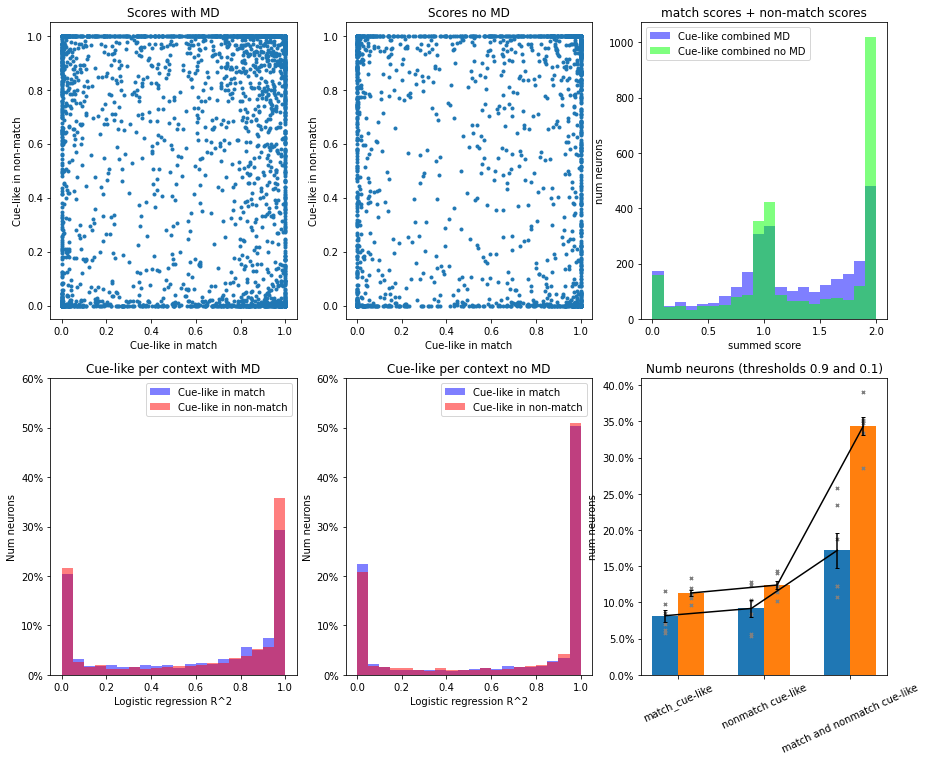

In [43]:
def plot_kmeans(ax, X):
    model = KMeans(n_clusters=5)
    model.fit(X)
    yhat = model.predict(X)
    clusters = np.unique(yhat)
    for cluster in clusters:
        row_ix = np.where(yhat == cluster)
        ax.scatter(X[row_ix, 0], X[row_ix, 1], marker=".")

fig = plt.figure(figsize=(15,12))
N_PFC_NEURONS = 500
hist_weights = np.ones(N_PFC_NEURONS * len(RUNS_MD)) / (N_PFC_NEURONS * len(RUNS_MD))

ax1 = fig.add_subplot(2,3,1)
ax1.scatter(scores[:,0],scores[:,1], marker=".")
ax1.set_xlabel("Cue-like in match")
ax1.set_ylabel("Cue-like in non-match")
ax1.set_title("Scores with MD")

ax2 = fig.add_subplot(2,3,4)
ax2.hist(scores[:,0], bins=20, fc=(0, 0, 1, 0.5), weights=hist_weights, label="Cue-like in match")
ax2.hist(scores[:,1], bins=20, fc=(1, 0, 0, 0.5), weights=hist_weights, label="Cue-like in non-match")
ax2.legend()
ax2.yaxis.set_major_formatter(PercentFormatter(1))
ax2.set_title("Cue-like per context with MD")
ax2.set_xlabel("Logistic regression R^2")
ax2.set_ylabel("Num neurons")
ax2.set_ylim((0,0.6))

ax3 = fig.add_subplot(2,3,2)
ax3.scatter(scores_noMD[:,0],scores_noMD[:,1], marker=".")
ax3.set_xlabel("Cue-like in match")
ax3.set_ylabel("Cue-like in non-match")
ax3.set_title("Scores no MD")

ax4 = fig.add_subplot(2,3,5)
w1 = np.ones(len(scores_noMD[:,0])) / len(scores_noMD[:,0])
ax4.hist(scores_noMD[:,0], bins=20, fc=(0, 0, 1, 0.5), weights=hist_weights, label="Cue-like in match")
ax4.hist(scores_noMD[:,1], bins=20, fc=(1, 0, 0, 0.5), weights=hist_weights, label="Cue-like in non-match")
ax4.legend()
ax4.yaxis.set_major_formatter(PercentFormatter(1))
ax4.set_title("Cue-like per context no MD")
ax4.set_xlabel("Logistic regression R^2")
ax4.set_ylabel("Num neurons")
ax4.set_ylim((0,0.6))

ax5 = fig.add_subplot(2,3,3)
ax5.hist(np.add(scores[:,0], scores[:,1]), bins=20, fc=(0, 0, 1, 0.5), label="Cue-like combined MD")
ax5.hist(np.add(scores_noMD[:,0], scores_noMD[:,1]), bins=20, fc=(0, 1, 0, 0.5), label="Cue-like combined no MD")
ax5.legend()
ax5.set_title("match scores + non-match scores")
ax5.set_xlabel("summed score")
ax5.set_ylabel("num neurons")

ax6 = fig.add_subplot(2,3,6)

def get_nums(s):
    num_cue1 = []
    num_cue2 = []
    num_cue = []
    for i in range(len(RUNS_MD)):
        i_low = i * N_PFC_NEURONS
        i_high = (i+1) * N_PFC_NEURONS
        num_cue1.append(len(np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] < 0.1))[0]))
        num_cue2.append(len(np.where(np.logical_and(s[i_low:i_high,1] > 0.9, s[i_low:i_high,0] < 0.1))[0]))
        num_cue.append(len(np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] > 0.9))[0]))
    return (num_cue1, num_cue2, num_cue)

(num_cue1_MD, num_cue2_MD, num_cue_MD) = get_nums(scores)
(num_cue1_noMD, num_cue2_noMD, num_cue_noMD) = get_nums(scores_noMD)
D = {}
D["match_cue-like"] = (num_cue1_MD, num_cue1_noMD)
D["nonmatch cue-like"] = (num_cue2_MD, num_cue2_noMD)
D["match and nonmatch cue-like"] = (num_cue_MD, num_cue_noMD)
plot_bars(ax6, D)
ax6.set_ylabel("num neurons")
ax6.set_title("Numb neurons (thresholds 0.9 and 0.1)")
plt.show()


{'match cue1': ([24, 13, 20, 25, 18, 21], [27, 21, 23, 21, 18, 24]), 'match cue2': ([34, 15, 21, 23, 12, 11], [26, 28, 14, 23, 27, 34]), 'nonmatch cue1': ([14, 26, 32, 36, 23, 14], [31, 36, 34, 27, 30, 23]), 'nonmatch cue2': ([14, 21, 30, 25, 19, 11], [30, 29, 28, 25, 20, 21]), 'both cue1': ([32, 31, 30, 35, 18, 19], [80, 56, 54, 51, 49, 62]), 'both cue2': ([24, 17, 30, 32, 15, 15], [86, 62, 68, 42, 61, 47]), 'both mixed': ([5, 46, 57, 62, 28, 20], [1, 58, 73, 50, 65, 65])}


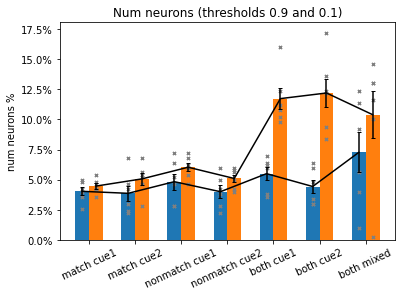

In [44]:
def get_nums7(s,b):
    match_cue1_neurons = []
    match_cue2_neurons = []
    nomatch_cue1_neurons = []
    nonmatch_cue2_neurons = []
    cuelike_cue1_neurons = []
    cuelike_cue2_neurons = []
    cuelike_mixed_neurons = []
        
    for i in range(len(RUNS_MD)):
        i_low = i * N_PFC_NEURONS
        i_high = (i+1) * N_PFC_NEURONS
        match_neurons    = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] < 0.1))[0]
        nonmatch_neurons = np.where(np.logical_and(s[i_low:i_high,1] > 0.9, s[i_low:i_high,0] < 0.1))[0]
        cuelike_neurons  = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] > 0.9))[0]

        match_cue1_neurons.append(len(match_neurons[np.where(b[match_neurons,0] == 1)[0]]))
        match_cue2_neurons.append(len(match_neurons[np.where(b[match_neurons,0] == -1)[0]]))
        nomatch_cue1_neurons.append(len(nonmatch_neurons[np.where(b[nonmatch_neurons,1] == 1)[0]]))
        nonmatch_cue2_neurons.append(len(nonmatch_neurons[np.where(b[nonmatch_neurons,1] == -1)[0]]))
        
        cuelike_cue1_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == 1, b[cuelike_neurons,1] == 1))[0]]
        cuelike_cue2_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == -1, b[cuelike_neurons,1] == -1))[0]]
        cuelike_cue1_neurons.append(len(cuelike_cue1_neurons_))
        cuelike_cue2_neurons.append(len(cuelike_cue2_neurons_))        
        cuelike_mixed_neurons.append(len(np.setdiff1d(cuelike_neurons, np.concatenate((cuelike_cue1_neurons_, cuelike_cue2_neurons_)))))
        
    return (match_cue1_neurons, match_cue2_neurons, nomatch_cue1_neurons, nonmatch_cue2_neurons, cuelike_cue1_neurons, cuelike_cue2_neurons, cuelike_mixed_neurons)
                                     
# match_neurons_noMD    = np.where(np.logical_and(scores_noMD[:,0] > 0.9, scores_noMD[:,1] < 0.1))[0]
# nonmatch_neurons_noMD = np.where(np.logical_and(scores_noMD[:,1] > 0.9, scores_noMD[:,0] < 0.1))[0]
# cuelike_neurons_noMD  = np.where(np.logical_and(scores_noMD[:,0] > 0.9, scores_noMD[:,1] > 0.9))[0]

# match_cue1_neurons_noMD    = match_neurons_noMD[np.where(b_noMD[match_neurons_noMD,0] == 1)[0]]
# match_cue2_neurons_noMD    = match_neurons_noMD[np.where(b_noMD[match_neurons_noMD,0] == -1)[0]]
# nomatch_cue1_neurons_noMD  = nonmatch_neurons_noMD[np.where(b[nonmatch_neurons_noMD,1] == 1)[0]]
# nonmatch_cue2_neurons_noMD = nonmatch_neurons_noMD[np.where(b[nonmatch_neurons_noMD,1] == -1)[0]]
# cuelike_cue1_neurons_noMD  = cuelike_neurons_noMD[np.where(np.logical_and(b[cuelike_neurons_noMD,0] == 1, b[cuelike_neurons_noMD,1] == 1))[0]]
# cuelike_cue2_neurons_noMD  = cuelike_neurons_noMD[np.where(np.logical_and(b[cuelike_neurons_noMD,0] == -1, b[cuelike_neurons_noMD,1] == -1))[0]]
# cuelike_mixed_neurons_noMD = np.setdiff1d(cuelike_neurons_noMD, np.concatenate((cuelike_cue1_neurons_noMD, cuelike_cue2_neurons_noMD)))
                                 
(num_match_cue1_neurons, num_match_cue2_neurons, num_nomatch_cue1_neurons, num_nonmatch_cue2_neurons, num_cuelike_cue1_neurons, num_cuelike_cue2_neurons, num_cuelike_mixed_neurons) = get_nums7(scores, b)
(num_match_cue1_neurons_noMD, num_match_cue2_neurons_noMD, num_nomatch_cue1_neurons_noMD, num_nonmatch_cue2_neurons_noMD, num_cuelike_cue1_neurons_noMD, num_cuelike_cue2_neurons_noMD, num_cuelike_mixed_neurons_noMD) = get_nums7(scores_noMD, b_noMD)
D = {}
D["match cue1"] = (num_match_cue1_neurons, num_match_cue1_neurons_noMD)
D["match cue2"] = (num_match_cue2_neurons, num_match_cue2_neurons_noMD)
D["nonmatch cue1"] = (num_nomatch_cue1_neurons, num_nomatch_cue1_neurons_noMD)
D["nonmatch cue2"] = (num_nonmatch_cue2_neurons, num_nonmatch_cue2_neurons_noMD)
D["both cue1"] = (num_cuelike_cue1_neurons, num_cuelike_cue1_neurons_noMD)
D["both cue2"] = (num_cuelike_cue2_neurons, num_cuelike_cue2_neurons_noMD)
D["both mixed"] = (num_cuelike_mixed_neurons, num_cuelike_mixed_neurons_noMD)                       
plot_bars(plt.gca(), D)
plt.ylabel("num neurons %")
plt.title("Num neurons (thresholds 0.9 and 0.1)")
                                     
print(D)

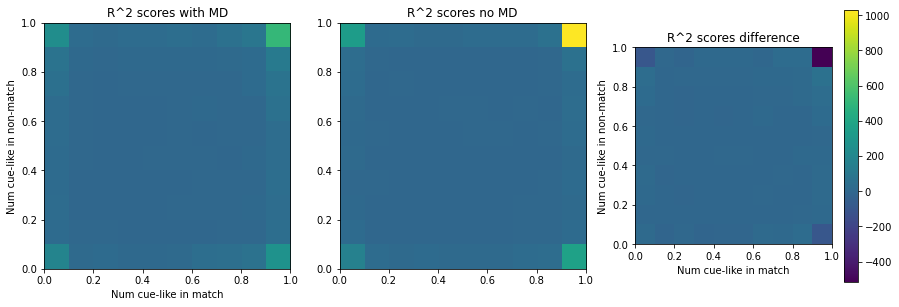

In [45]:
fig = plt.figure(figsize=(15,5))

H1, xedges, yedges = np.histogram2d(scores[:,0], scores[:,1], bins=10)
H2, _, _ = np.histogram2d(scores_noMD[:,0], scores_noMD[:,1], bins=10)
H3 = np.subtract(H1, H2)

vmax = max(np.max(H1),np.max(H2))
vmin = np.min(H3)

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(H1, vmin=vmin, vmax=vmax, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax1.set_title("R^2 scores with MD")
ax1.set_xlabel("Num cue-like in match")
ax1.set_ylabel("Num cue-like in non-match")

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(H2, vmin=vmin, vmax=vmax, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax2.set_title("R^2 scores no MD")
ax1.set_xlabel("Num cue-like in match")
ax1.set_ylabel("Num cue-like in non-match")

ax3 = fig.add_subplot(1,3,3)
im = ax3.imshow(H3, vmin=vmin, vmax=vmax, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax3.set_title("R^2 scores difference")
ax3.set_xlabel("Num cue-like in match")
ax3.set_ylabel("Num cue-like in non-match")

fig.colorbar(im)

plt.show()

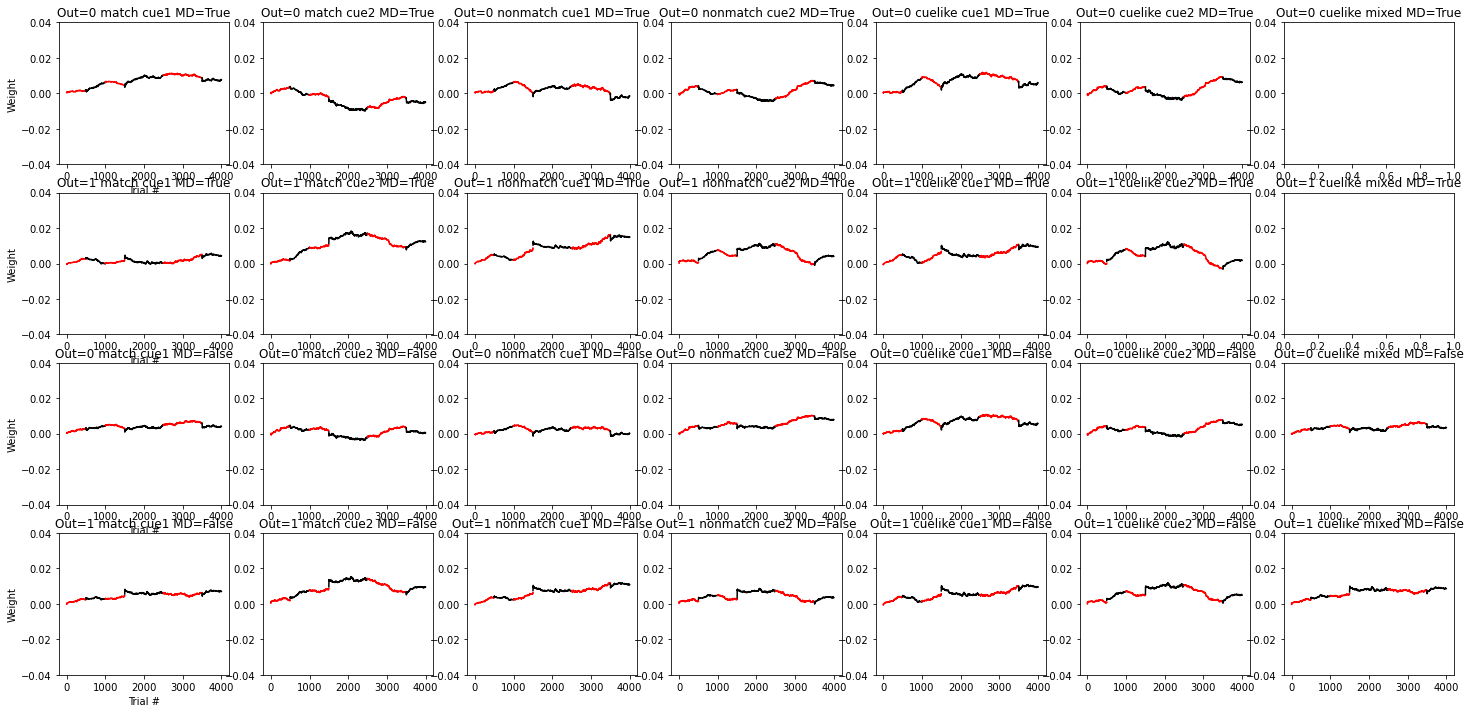

In [32]:
cue1_MD_idxs    = np.where(np.logical_and(scores[:,0] > 0.9, scores[:,1] < 0.1))[0]
cue2_MD_idxs    = np.where(np.logical_and(scores[:,1] > 0.9, scores[:,0] < 0.1))[0]
cuelike_MD_idxs = np.concatenate((cue1_MD_idxs, cue2_MD_idxs))
cue1_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,0] > 0.9, scores_noMD[:,1] < 0.1))[0]
cue2_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,1] > 0.9, scores_noMD[:,0] < 0.1))[0]
cuelike_noMD_idxs = np.concatenate((cue1_noMD_idxs, cue2_noMD_idxs))

x = np.arange(0,4000)
wPFC_out0_all = wPFC_output[match_trials,0,:]
wPFC_out1_all = wPFC_output[match_trials,1,:]
wPFC_out0_all_noMD = wPFC_output_noMD[match_trials,0,:]
wPFC_out1_all_noMD = wPFC_output_noMD[match_trials,1,:]

# match_cue1_neurons    = match_neurons[np.where(b[match_neurons,0] == 1)[0]]
# match_cue2_neurons    = match_neurons[np.where(b[match_neurons,0] == -1)[0]]
# nomatch_cue1_neurons  = nonmatch_neurons[np.where(b[nonmatch_neurons,1] == 1)[0]]
# nonmatch_cue2_neurons = nonmatch_neurons[np.where(b[nonmatch_neurons,1] == -1)[0]]
# cuelike_cue1_neurons  = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == 1, b[cuelike_neurons,1] == 1))[0]]
# cuelike_cue2_neurons  = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == -1, b[cuelike_neurons,1] == -1))[0]]
# cuelike_mixed_neurons

m0 = np.mean(wPFC_out0_all,1)
m1 = np.mean(wPFC_out1_all,1)
e0 = np.std(wPFC_out0_all,1) / math.sqrt(wPFC_out0_all.shape[1])
e1 = np.std(wPFC_out1_all,1) / math.sqrt(wPFC_out1_all.shape[1])

m0_noMD = np.mean(wPFC_out0_all_noMD,1)
m1_noMD = np.mean(wPFC_out1_all_noMD,1)
e0_noMD = np.std(wPFC_out0_all_noMD,1) / math.sqrt(wPFC_out0_all_noMD.shape[1])
e1_noMD = np.std(wPFC_out1_all_noMD,1) / math.sqrt(wPFC_out1_all_noMD.shape[1])

wPFC_out0_match_cue1_MD = wPFC_output[:,0,match_cue1_neurons]
wPFC_out0_match_cue2_MD = wPFC_output[:,0,match_cue2_neurons]
wPFC_out0_nonmatch_cue1_MD = wPFC_output[:,0,nomatch_cue1_neurons]
wPFC_out0_nonmatch_cue2_MD = wPFC_output[:,0,nonmatch_cue2_neurons]
wPFC_out0_cuelike_cue1_MD = wPFC_output[:,0,cuelike_cue1_neurons]
wPFC_out0_cuelike_cue2_MD = wPFC_output[:,0,cuelike_cue2_neurons]
wPFC_out0_cuelike_mixed_MD = wPFC_output[:,0,cuelike_mixed_neurons]

wPFC_out1_match_cue1_MD = wPFC_output[:,1,match_cue1_neurons]
wPFC_out1_match_cue2_MD = wPFC_output[:,1,match_cue2_neurons]
wPFC_out1_nonmatch_cue1_MD = wPFC_output[:,1,nomatch_cue1_neurons]
wPFC_out1_nonmatch_cue2_MD = wPFC_output[:,1,nonmatch_cue2_neurons]
wPFC_out1_cuelike_cue1_MD = wPFC_output[:,1,cuelike_cue1_neurons]
wPFC_out1_cuelike_cue2_MD = wPFC_output[:,1,cuelike_cue2_neurons]
wPFC_out1_cuelike_mixed_MD = wPFC_output[:,1,cuelike_mixed_neurons]

wPFC_out0_match_cue1_noMD = wPFC_output[:,0,match_cue1_neurons_noMD]
wPFC_out0_match_cue2_noMD = wPFC_output[:,0,match_cue2_neurons_noMD]
wPFC_out0_nonmatch_cue1_noMD = wPFC_output[:,0,nomatch_cue1_neurons_noMD]
wPFC_out0_nonmatch_cue2_noMD = wPFC_output[:,0,nonmatch_cue2_neurons_noMD]
wPFC_out0_cuelike_cue1_noMD = wPFC_output[:,0,cuelike_cue1_neurons_noMD]
wPFC_out0_cuelike_cue2_noMD = wPFC_output[:,0,cuelike_cue2_neurons_noMD]
wPFC_out0_cuelike_mixed_noMD = wPFC_output[:,0,cuelike_mixed_neurons_noMD]

wPFC_out1_match_cue1_noMD = wPFC_output[:,1,match_cue1_neurons_noMD]
wPFC_out1_match_cue2_noMD = wPFC_output[:,1,match_cue2_neurons_noMD]
wPFC_out1_nonmatch_cue1_noMD = wPFC_output[:,1,nomatch_cue1_neurons_noMD]
wPFC_out1_nonmatch_cue2_noMD = wPFC_output[:,1,nonmatch_cue2_neurons_noMD]
wPFC_out1_cuelike_cue1_noMD = wPFC_output[:,1,cuelike_cue1_neurons_noMD]
wPFC_out1_cuelike_cue2_noMD = wPFC_output[:,1,cuelike_cue2_neurons_noMD]
wPFC_out1_cuelike_mixed_noMD = wPFC_output[:,1,cuelike_mixed_neurons_noMD]

def plt_trials(ax, w):
    if w.shape[1] == 0:
        return
    
    match_blocks = [1,3,4,7]
    nmatch_blocks = [0,2,5,6]

#     for block in range(0,8):
#         c = 'k' if block in match_blocks else 'r'
#         s = block * 500
#         t = block * 500 + 500
#         ax.plot(np.arange(s,t), w[s:t,:], c, alpha=0.1)
        
    for block in range(0,8):
        c = 'k' if block in match_blocks else 'r'
        s = block * 500
        t = block * 500 + 500
        m = np.mean(w[s:t,:],1)
        e = np.std(w[s:t,:],1)        
        ax.plot(np.arange(s,t), np.mean(w[s:t,:], 1), c)
#         ax.fill_between(np.arange(s,t), m-e, m+e, color=c, alpha=0.3)

fig = plt.figure(figsize=(25,12))

ax1 = fig.add_subplot(4,7,1)
plt_trials(ax1,wPFC_out0_match_cue1_MD)
ax1.set_ylim((-0.04,0.04))
ax1.set_title("Out=0 match cue1 MD=True")
ax1.set_xlabel("Trial #")
ax1.set_ylabel("Weight")

ax2 = fig.add_subplot(4,7,2)
plt_trials(ax2,wPFC_out0_match_cue2_MD)
ax2.set_ylim((-0.04,0.04))
ax2.set_title("Out=0 match cue2 MD=True")

ax3 = fig.add_subplot(4,7,3)
plt_trials(ax3,wPFC_out0_nonmatch_cue1_MD)
ax3.set_ylim((-0.04,0.04))
ax3.set_title("Out=0 nonmatch cue1 MD=True")

ax4 = fig.add_subplot(4,7,4)
plt_trials(ax4,wPFC_out0_nonmatch_cue2_MD)
ax4.set_ylim((-0.04,0.04))
ax4.set_title("Out=0 nonmatch cue2 MD=True")

ax5 = fig.add_subplot(4,7,5)
plt_trials(ax5,wPFC_out0_cuelike_cue1_MD)
ax5.set_ylim((-0.04,0.04))
ax5.set_title("Out=0 cuelike cue1 MD=True")

ax6 = fig.add_subplot(4,7,6)
plt_trials(ax6,wPFC_out0_cuelike_cue2_MD)
ax6.set_ylim((-0.04,0.04))
ax6.set_title("Out=0 cuelike cue2 MD=True")

ax7 = fig.add_subplot(4,7,7)
plt_trials(ax7,wPFC_out0_cuelike_mixed_MD)
ax7.set_ylim((-0.04,0.04))
ax7.set_title("Out=0 cuelike mixed MD=True")

ax8 = fig.add_subplot(4,7,8)
plt_trials(ax8,wPFC_out1_match_cue1_MD)
ax8.set_ylim((-0.04,0.04))
ax8.set_title("Out=1 match cue1 MD=True")
ax8.set_xlabel("Trial #")
ax8.set_ylabel("Weight")

ax9 = fig.add_subplot(4,7,9)
plt_trials(ax9,wPFC_out1_match_cue2_MD)
ax9.set_ylim((-0.04,0.04))
ax9.set_title("Out=1 match cue2 MD=True")

ax10 = fig.add_subplot(4,7,10)
plt_trials(ax10,wPFC_out1_nonmatch_cue1_MD)
ax10.set_ylim((-0.04,0.04))
ax10.set_title("Out=1 nonmatch cue1 MD=True")

ax11 = fig.add_subplot(4,7,11)
plt_trials(ax11,wPFC_out1_nonmatch_cue2_MD)
ax11.set_ylim((-0.04,0.04))
ax11.set_title("Out=1 nonmatch cue2 MD=True")

ax12 = fig.add_subplot(4,7,12)
plt_trials(ax12,wPFC_out1_cuelike_cue1_MD)
ax12.set_ylim((-0.04,0.04))
ax12.set_title("Out=1 cuelike cue1 MD=True")

ax13 = fig.add_subplot(4,7,13)
plt_trials(ax13,wPFC_out1_cuelike_cue2_MD)
ax13.set_ylim((-0.04,0.04))
ax13.set_title("Out=1 cuelike cue2 MD=True")

ax14 = fig.add_subplot(4,7,14)
plt_trials(ax14,wPFC_out1_cuelike_mixed_MD)
ax14.set_ylim((-0.04,0.04))
ax14.set_title("Out=1 cuelike mixed MD=True")

ax15 = fig.add_subplot(4,7,15)
plt_trials(ax15,wPFC_out0_match_cue1_noMD)
ax15.set_ylim((-0.04,0.04))
ax15.set_title("Out=0 match cue1 MD=False")
ax15.set_xlabel("Trial #")
ax15.set_ylabel("Weight")

ax16 = fig.add_subplot(4,7,16)
plt_trials(ax16,wPFC_out0_match_cue2_noMD)
ax16.set_ylim((-0.04,0.04))
ax16.set_title("Out=0 match cue2 MD=False")

ax17 = fig.add_subplot(4,7,17)
plt_trials(ax17,wPFC_out0_nonmatch_cue1_noMD)
ax17.set_ylim((-0.04,0.04))
ax17.set_title("Out=0 nonmatch cue1 MD=False")

ax18 = fig.add_subplot(4,7,18)
plt_trials(ax18,wPFC_out0_nonmatch_cue2_noMD)
ax18.set_ylim((-0.04,0.04))
ax18.set_title("Out=0 nonmatch cue2 MD=False")

ax19 = fig.add_subplot(4,7,19)
plt_trials(ax19,wPFC_out0_cuelike_cue1_noMD)
ax19.set_ylim((-0.04,0.04))
ax19.set_title("Out=0 cuelike cue1 MD=False")

ax20 = fig.add_subplot(4,7,20)
plt_trials(ax20,wPFC_out0_cuelike_cue2_noMD)
ax20.set_ylim((-0.04,0.04))
ax20.set_title("Out=0 cuelike cue2 MD=False")

ax21 = fig.add_subplot(4,7,21)
plt_trials(ax21,wPFC_out0_cuelike_mixed_noMD)
ax21.set_ylim((-0.04,0.04))
ax21.set_title("Out=0 cuelike mixed MD=False")

ax22 = fig.add_subplot(4,7,22)
plt_trials(ax22,wPFC_out1_match_cue1_noMD)
ax22.set_ylim((-0.04,0.04))
ax22.set_title("Out=1 match cue1 MD=False")
ax22.set_xlabel("Trial #")
ax22.set_ylabel("Weight")

ax23 = fig.add_subplot(4,7,23)
plt_trials(ax23,wPFC_out1_match_cue2_noMD)
ax23.set_ylim((-0.04,0.04))
ax23.set_title("Out=1 match cue2 MD=False")

ax24 = fig.add_subplot(4,7,24)
plt_trials(ax24,wPFC_out1_nonmatch_cue1_noMD)
ax24.set_ylim((-0.04,0.04))
ax24.set_title("Out=1 nonmatch cue1 MD=False")

ax25 = fig.add_subplot(4,7,25)
plt_trials(ax25,wPFC_out1_nonmatch_cue2_noMD)
ax25.set_ylim((-0.04,0.04))
ax25.set_title("Out=1 nonmatch cue2 MD=False")

ax26 = fig.add_subplot(4,7,26)
plt_trials(ax26,wPFC_out1_cuelike_cue1_noMD)
ax26.set_ylim((-0.04,0.04))
ax26.set_title("Out=1 cuelike cue1 MD=False")

ax27 = fig.add_subplot(4,7,27)
plt_trials(ax27,wPFC_out1_cuelike_cue2_noMD)
ax27.set_ylim((-0.04,0.04))
ax27.set_title("Out=1 cuelike cue2 MD=False")

ax28 = fig.add_subplot(4,7,28)
plt_trials(ax28,wPFC_out1_cuelike_mixed_noMD)
ax28.set_ylim((-0.04,0.04))
ax28.set_title("Out=1 cuelike mixed MD=False")

plt.show()


In [ ]:
# fig = plt.figure(figsize=(15,12))

# ax1 = fig.add_subplot(2,2,1)
# ax1.plot(x, np.mean(wPFC_out0_all,1), color=(0,0,1,0.4), label="Out=0 all")
# ax1.fill_between(x, m0-e0, m0+e0, color=(0,0,1,0.1))
# ax1.plot(x, np.mean(wPFC_out1_all,1), color=(1,0,0,0.4), label="Out=1 all")
# ax1.fill_between(x, m1-e1, m1+e1, color=(1,0,0,0.1))
# ax1.plot(x, np.mean(wPFC_out0_cue1_MD,1), color=(0,1,1), label="Out=0 cue1-like")
# ax1.plot(x, np.mean(wPFC_out1_cue1_MD,1), color=(1,0,1), label="Out=1 cue1-like")
# ax1.set_ylim((-.001,.010))
# ax1.set_xlabel("Trial #")
# ax1.set_ylabel("Weight")
# ax1.set_title("wPFC Cue=1 MD=True")
# ax1.legend()

# ax2 = fig.add_subplot(2,2,2)
# ax2.plot(x, np.mean(wPFC_out0_all,1), color=(0,0,1,0.4), label="Out=0 all")
# ax2.fill_between(x, m0-e0, m0+e0, color=(0,0,1,0.1))
# ax2.plot(x, np.mean(wPFC_out1_all,1), color=(1,0,0,0.4), label="Out=1 all")
# ax2.fill_between(x, m1-e1, m1+e1, color=(1,0,0,0.1))
# ax2.plot(x, np.mean(wPFC_out0_cue2_MD,1), color=(0,1,1), label="Out=0 cue2-like")
# ax2.plot(x, np.mean(wPFC_out1_cue2_MD,1), color=(1,0,1), label="Out=1 cue2-like")
# ax2.set_ylim((-.001,.010))
# ax2.set_title("wPFC Cue=2 MD=True")
# ax2.legend()

# ax3 = fig.add_subplot(2,2,3)
# ax3.plot(x, np.mean(wPFC_out0_all_noMD,1), color=(0,0,1,0.4), label="Out=0 all")
# ax3.fill_between(x, m0_noMD-e0_noMD, m0_noMD+e0_noMD, color=(0,0,1,0.1))
# ax3.plot(x, np.mean(wPFC_out1_all_noMD,1), color=(1,0,0,0.4), label="Out=1 all")
# ax3.fill_between(x, m1_noMD-e1_noMD, m1_noMD+e1_noMD, color=(1,0,0,0.1))
# ax3.plot(x, np.mean(wPFC_out0_cue1_noMD,1), color=(0,1,1), label="Out=0 cue1-like")
# ax3.plot(x, np.mean(wPFC_out1_cue1_noMD,1), color=(1,0,1), label="Out=1 cue1-like")
# ax3.set_ylim((-.001,.010))
# ax3.set_title("wPFC Cue=1 MD=False")
# ax3.legend()

# ax4 = fig.add_subplot(2,2,4)
# ax4.plot(x, np.mean(wPFC_out0_all_noMD,1), color=(0,0,1,0.4), label="Out=0 all")
# ax4.fill_between(x, m0_noMD-e0_noMD, m0_noMD+e0_noMD, color=(0,0,1,0.1))
# ax4.plot(x, np.mean(wPFC_out1_all_noMD,1), color=(1,0,0,0.4), label="Out=1 all")
# ax4.fill_between(x, m1_noMD-e1_noMD, m1_noMD+e1_noMD, color=(1,0,0,0.1))
# ax4.plot(x, np.mean(wPFC_out0_cue2_noMD,1), color=(0,1,1), label="Out=0 cue2-like")
# ax4.plot(x, np.mean(wPFC_out1_cue2_noMD,1), color=(1,0,1), label="Out=1 cue2-like")
# ax4.set_ylim((-.001,.010))
# ax4.set_title("wPFC Cue=2 MD=False")
# ax4.legend()

# plt.show()

def moving_average(X, w):
    C = []
    for i in range(0,X.shape[0]):
        c = np.convolve(X[i,:], np.ones(w), 'valid')
        C = c if len(C) == 0 else np.vstack((C,c))
    print(C.shape)
    return C
